<a href="https://colab.research.google.com/github/lucacontalbo/NLPProject/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***change your own path here (local)*** 

In [ ]:
base_path = '/Users/soulofshadow/Desktop/NLPproject/'

***change your own path here (colab)***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/Colab_Notebooks/nlp project/project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_path = '/content/drive/MyDrive/project/'


***install tools***

In [ ]:
!pip install transformers
!pip install trectools
!pip install sentence-transformers
!pip install rank_bm25
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. First procedure: prepare data

### Libraries

In [ ]:
import pandas as pd
import tensorflow as tf
import torch
from torch import nn
import torch.optim as optim
import numpy as np
import sys
from codecarbon import EmissionsTracker

import matplotlib.pyplot as plt
%matplotlib inline


from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, AutoModelForCausalLM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.spatial.distance import cosine
import datetime

import os
import random

sys.path.append(base_path)

from scorer.main import evaluate
from functools import partial

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Load Data

In [ ]:
train = pd.read_csv(base_path+'train_dataset')
dev = pd.read_csv(base_path+'dev_dataset')

train = train.drop('Unnamed: 0',axis=1)
train = train.drop('0',axis=1)
#train = train.drop('1',axis=1)
train[train.duplicated(['tweet_id'], keep=False)]

dev = dev.drop('Unnamed: 0',axis=1)
dev = dev.drop('0',axis=1)
#dev = dev.drop('1',axis=1)
dev[dev.duplicated(['tweet_id'], keep=False)]

vclaim = pd.read_csv(base_path+'vclaim_dataset.csv',sep=',')

#create train - val - test separation
val = train[800:].copy()
test = dev
train = train[:800].copy()

In [ ]:
train.head()

,tweet_id,vclaim_id,1,tweet,vclaim
0,tweet-sno-0,vclaim-sno-hero-wombats-australia-fires,1,How are butterflies surviving the #AustralianF...,Wombats are herding animals and inviting them ...
1,tweet-sno-1,vclaim-sno-ilhan-omar-treason-advice-iran,1,Trump needs to immediately divest from his bus...,"In January 2020, U.S. Rep. Ilhan Omar advised ..."
2,tweet-sno-2,vclaim-sno-us-army-sending-texts-on-draft,1,A number of fraudulent text messages informing...,The U.S. Army is sending text messages informi...
3,tweet-sno-3,vclaim-sno-us-army-sending-texts-on-draft,1,Fact check: The U.S. Army is NOT contacting an...,The U.S. Army is sending text messages informi...
4,tweet-sno-4,vclaim-sno-video-of-drone-strike-soleimani,1,The US drone attack on #Soleimani caught on ca...,A video shows the U.S.-ordered drone strike th...


In [ ]:
test.head()

,tweet_id,vclaim_id,1,tweet,vclaim
0,tweet-sno-999,vclaim-sno-single-mother-birth-certificate,1,Republicans in Illinois don't want the child o...,Lawmakers in Illinois proposed a bill to preve...
1,tweet-sno-1000,vclaim-sno-single-mother-birth-certificate,1,Illinois GOP bill attacks single moms: No birt...,Lawmakers in Illinois proposed a bill to preve...
2,tweet-sno-1001,vclaim-sno-michael-savage-removed,1,michael savage who has more viewers then all m...,Radio personality Michael Savage was fired bec...
3,tweet-sno-1002,vclaim-sno-alabama-food-stamps-car,1,The Montgomery Idiocracy strikes again: Alabam...,Republicans in Alabama filed a bill which (if ...
4,tweet-sno-1003,vclaim-sno-alabama-food-stamps-car,1,In Alabama you won't be able to own a car & ge...,Republicans in Alabama filed a bill which (if ...


In [ ]:
vclaim.head()

,Unnamed: 0,title,subtitle,author,date,vclaim_id,vclaim
0,0,Doctored Spock,Did the son of baby specialist Dr. Spock kill ...,David Mikkelson,9 September 2002,vclaim-sno-doctored-spock,The son of child care expert Dr. Benjamin Spoc...
1,1,Maryland Doctor Who Treated Hillary Clinton fo...,Fabricated conspiracy theory holds that Hillar...,David Mikkelson,15 October 2016,vclaim-sno-doctor-who-treated-hillary-clinton-...,A Maryland doctor who participated in a secret...
2,2,"Doctor Saves Baby, Baby Saves Doctor",An incredible story about a doctor and a param...,Dan Evon,25 April 2016,vclaim-sno-doctor-saves-baby-karma,A paramedic saved the doctor who had saved his...
3,3,Is This a Doctor Mourning a Woman Who Died Dur...,A photograph reportedly depicts a crying docto...,Kim LaCapria,6 September 2017,vclaim-sno-doctor-mourning-previously-infertil...,An image depicts a obstetrician grieving after...
4,4,Medicare and Guns,Medicare regulations do not require that docto...,David Mikkelson,26 March 2012,vclaim-sno-doctor-know,Medicare regulations require that doctors ask ...


In [ ]:
vclaim.loc[vclaim["vclaim_id"] == "vclaim-sno-video-of-drone-strike-soleimani"]

,Unnamed: 0,title,subtitle,author,date,vclaim_id,vclaim
2221,2221,Does This Video Show the Drone Strike That Kil...,Iran Gen. Qassem Soleimani was killed by a U.S...,Dan Evon,7 January 2020,vclaim-sno-video-of-drone-strike-soleimani,A video shows the U.S.-ordered drone strike th...


In [ ]:
train.nunique()

tweet_id     800
vclaim_id    634
1              1
tweet        800
vclaim       634
dtype: int64

In [ ]:
test.nunique(), dev.shape

(tweet_id     199
 vclaim_id    150
 1              1
 tweet        199
 vclaim       150
 dtype: int64, (200, 5))

### Pre-Processing

In [ ]:
# Pre-processing
from functools import reduce
import re

def remove_end(txt):
  #return txt[:txt.rfind('—')]
  txt = txt[:txt.rfind('—')]
  return re.sub('—.+?, [0-9]+','',txt)

def remove_escaped(txt):
  return re.sub(r'&\S+','',txt)

def remove_urls(txt):
  txt = re.sub(r'http\S+','',txt)
  txt = re.sub(r'pic.\S+','',txt)
  txt = re.sub(r'twitter.\S+','',txt)
  return txt

def remove_char_to_space(txt,char):
  return re.sub(char+'\S+','',txt)

def remove_mentions(txt):
  return remove_char_to_space(txt,'@')

def remove_hashtags(txt):
  return remove_char_to_space(txt,'#')

def remove_emoji(txt):
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', txt) # no emoji

def remove_leading_spaces(txt):
  return txt.strip()

def text_preprocess(txt):
  text_process_list = [remove_escaped,remove_urls,remove_emoji,remove_end]#,remove_emoji,remove_hashtags,remove_mentions,remove_end,remove_leading_spaces]
  txt = reduce(lambda txt,func: func(txt),text_process_list,txt)
  return txt

train['tweet'] = train['tweet'].apply(lambda x: text_preprocess(x))
val['tweet'] = val['tweet'].apply(lambda x: text_preprocess(x))
test['tweet'] = test['tweet'].apply(lambda x: text_preprocess(x))

"""
print('Pre-processing evidence...')
train['tweet'] = train['tweet'].apply(lambda txt: text_prepare(txt))
train['vclaim'] = train['vclaim'].apply(lambda txt: text_prepare(txt))

dev['tweet'] = dev['tweet'].apply(lambda txt: text_prepare(txt))
dev['vclaim'] = dev['vclaim'].apply(lambda txt: text_prepare(txt))

vclaim['vclaim'] = vclaim['vclaim'].apply(lambda txt: text_prepare(txt))

print("Pre-processing completed!")"""
train.head()

,tweet_id,vclaim_id,1,tweet,vclaim
0,tweet-sno-0,vclaim-sno-hero-wombats-australia-fires,1,How are butterflies surviving the #AustralianF...,Wombats are herding animals and inviting them ...
1,tweet-sno-1,vclaim-sno-ilhan-omar-treason-advice-iran,1,Trump needs to immediately divest from his bus...,"In January 2020, U.S. Rep. Ilhan Omar advised ..."
2,tweet-sno-2,vclaim-sno-us-army-sending-texts-on-draft,1,A number of fraudulent text messages informing...,The U.S. Army is sending text messages informi...
3,tweet-sno-3,vclaim-sno-us-army-sending-texts-on-draft,1,Fact check: The U.S. Army is NOT contacting an...,The U.S. Army is sending text messages informi...
4,tweet-sno-4,vclaim-sno-video-of-drone-strike-soleimani,1,The US drone attack on #Soleimani caught on ca...,A video shows the U.S.-ordered drone strike th...


# 2. Scores on syntactical + pre-trained semantic

Here we test several models (bm25, tf-idf, simple RNNs, LSTM and pretrained models, like bert and sgpt).
We do not apply any training yet, but we just see which is the model with the best score and what are the baselines, with their scores

In [ ]:
import json

def sortdict(dictionary):
  for k,v in dictionary.items():
    v = np.array(v)
    dictionary[k] = v[np.argsort(v[:,1].astype(np.float))][::-1].tolist()
  return dictionary

def parse2file(dictionary,file_path):
  with open(base_path+file_path,'w') as f:
    for k,v in dictionary.items():
      str_score = ''
      for i in range(len(v)):
        str_score += k+'\tQ0\t'+v[i][0]+'\t'+str(i+1)+'\t'+str(v[i][1])+'\ttrained\n'
      f.write(str_score)

def score(baseline_txt):
  maps, mrr, precisions = evaluate(base_path+'qrels-dev.tsv', base_path+baseline_txt)
  print(f"NoTuning Baseline for Subtask-2a--english")
  print(f'All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. {maps}')
  print(f'MRR score {mrr}')
  return maps,mrr,precisions
  #print(f'All P scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. {precisions}')

def calculate_similarity(model,embeddings,json_file,result_file):
  tweet2vclaim = {}
  for i,tweet_row in test.iterrows():
      tweet = tweet_row['tweet']
      id = tweet_row['tweet_id']
      if id not in tweet2vclaim.keys():
          tweet2vclaim[id] = []
    
      tweet_embed = model.encode(tweet, convert_to_tensor=True)
      score_cos = util.cos_sim(tweet_embed, embeddings)[0].tolist()

      for j in range(len(score_cos)):
          tweet2vclaim[id].append([vclaim.vclaim_id[j], score_cos[j]])

  sortdict(tweet2vclaim)
  parse2file(tweet2vclaim,result_file)

In [ ]:
TYPE = 1 #0: vclaim, 1: vclaim+title, 2: vclaim+title+subtitle

if TYPE == 0:
  sentences = vclaim['title'].str.tolist()
elif TYPE == 1:
  sentences = vclaim['title'].str.cat(vclaim['vclaim'], sep = ' ').values.tolist()
else:
  sentences = vclaim['title'].str.cat(vclaim['subtitle'].str.cat(vclaim['vclaim'], sep=' '), sep = ' ').values.tolist()


### BM25 try

In [ ]:
from rank_bm25 import BM25Okapi

sentences = vclaim['title'].str.cat(vclaim['vclaim'], sep = ' ')
docs = []

for sentence in sentences:
    sentence = str(sentence)
    sentence_words = sentence.split()
    docs.append(sentence_words)

tracker = EmissionsTracker(output_dir=base_path+'analysis/co2/')
tracker.start()

bm25 = BM25Okapi(docs)

[codecarbon INFO @ 12:43:14] [setup] RAM Tracking...
[codecarbon INFO @ 12:43:14] [setup] GPU Tracking...
[codecarbon INFO @ 12:43:14] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:43:14] [setup] CPU Tracking...
[codecarbon WARNING @ 12:43:14] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 12:43:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 12:43:15] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 12:43:15] >>> Tracker's metadata:
[codecarbon INFO @ 12:43:15]   Platform system: Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic
[codecarbon INFO @ 12:43:15]   Python version: 3.7.14
[codecarbon INFO @ 12:43:15]   Available RAM : 51.000 GB
[codecarbon INFO @ 12:43:15]   CPU count: 8
[codecarbon INFO @ 12:43:15]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 12:43:15]   GPU count: 1
[codecarbon INFO @ 12:43:15]   GPU mod

In [ ]:
tweet2vclaim = {}
for i,tweet_row in test.iterrows():
    tweet = tweet_row['tweet']
    id = tweet_row['tweet_id']
    if id not in tweet2vclaim.keys():
        tweet2vclaim[id] = []
    vclaim['score'] = bm25.get_scores(tweet.split(" "))
    tweet2vclaim[id] = [[id, score] for id, score in zip(vclaim.vclaim_id,vclaim.score)]

print(tracker.stop())

with open(base_path+'bm25dict.json','w') as f: #I save, from time to time, the data obtained in case of crash
      json.dump(tweet2vclaim,f)

[codecarbon INFO @ 12:43:30] Energy consumed for RAM : 0.000080 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 12:43:30] Energy consumed for all GPUs : 0.000110 kWh. All GPUs Power : 26.310000000000002 W
[codecarbon INFO @ 12:43:30] Energy consumed for all CPUs : 0.000178 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 12:43:30] 0.000367 kWh of electricity used since the begining.
[codecarbon INFO @ 12:43:33] Energy consumed for RAM : 0.000094 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 12:43:33] Energy consumed for all GPUs : 0.000130 kWh. All GPUs Power : 26.378000000000004 W
[codecarbon INFO @ 12:43:33] Energy consumed for all CPUs : 0.000210 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 12:43:33] 0.000434 kWh of electricity used since the begining.


0.00013800505742079755


In [ ]:
with open(base_path+'bm25dict.json','r') as f:
  tweet2vclaim = json.load(f)
  tweet2vclaim = sortdict(tweet2vclaim)
  parse2file(tweet2vclaim,'bm25result.txt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
score('bm25result.txt')

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.5050251256281407, 0.5452261306532663, 0.5532663316582914, 0.5573143495254048, 0.5603803301667623, 0.5614416010453704, 0.5620875371933731]
MRR score 0.5595749743793027


([0.5050251256281407,
  0.5452261306532663,
  0.5532663316582914,
  0.5573143495254048,
  0.5603803301667623,
  0.5614416010453704,
  0.5620875371933731],
 0.5595749743793027,
 1)

### TF-IDF try

In [ ]:
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

xtrain_corpus = test['tweet'].tolist()
ytrain_corpus = [' '.join(list(a)) for a in zip(vclaim['vclaim'],vclaim['title'])]

vectorizer =  TfidfVectorizer()

X_train = vectorizer.fit_transform(xtrain_corpus)
Y_train = vectorizer.transform(ytrain_corpus)

tracker = EmissionsTracker(output_dir=base_path+'analysis/co2/')
tracker.start()

cosine = cosine_similarity(X_train,Y_train)

tfidf_dict = {}
for i in range(len(cosine)):
  tweet_id = test.iloc[i]['tweet_id']
  tfidf_dict[tweet_id] = []
  for j in range(len(cosine[i])):
    vclaim_id = vclaim.vclaim_id[j]
    tfidf_dict[tweet_id].append([vclaim_id,cosine[i][j]])

print(tracker.stop())

with open(base_path+'tfidfdict.json','w') as f: #I save, from time to time, the data obtained in case of crash
  json.dump(tfidf_dict,f)

[codecarbon INFO @ 16:24:05] [setup] RAM Tracking...
[codecarbon INFO @ 16:24:05] [setup] GPU Tracking...
[codecarbon INFO @ 16:24:05] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:24:05] [setup] CPU Tracking...
[codecarbon WARNING @ 16:24:05] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 16:24:07] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:24:07] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 16:24:07] >>> Tracker's metadata:
[codecarbon INFO @ 16:24:07]   Platform system: Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic
[codecarbon INFO @ 16:24:07]   Python version: 3.7.14
[codecarbon INFO @ 16:24:07]   Available RAM : 51.000 GB
[codecarbon INFO @ 16:24:07]   CPU count: 8
[codecarbon INFO @ 16:24:07]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 16:24:07]   GPU count: 1
[codecarbon INFO @ 16:24:07]   GPU mod

0.00020186050409603856


In [ ]:
with open(base_path+'tfidfdict.json','r') as f:
  tfidf_dict = json.load(f)
  tfidf_dict = sortdict(tfidf_dict)
  parse2file(tfidf_dict,'tfidf_result.txt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
score('tfidf_result.txt')

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.6959798994974874, 0.7252931323283082, 0.7365996649916247, 0.7424802584350323, 0.7443316524346674, 0.744839370409681, 0.7451124189922477]
MRR score 0.7425998561781774


### BERT try

In [ ]:
from sentence_transformers import SentenceTransformer, InputExample, losses, util
from torch.utils.data import DataLoader

# i choosed one pre-model from a chart table says this one is good lmao

model = SentenceTransformer('all-mpnet-base-v2')

train_bert_text = []
for i,row in train.iterrows():
    text = []
    text.append(row['tweet'])
    text.append(row['vclaim'])
    train_bert_text.append(text)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/file_download.py:591: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


Using Maximum Sequence Length:  384


In [ ]:
tracker = EmissionsTracker(output_dir=base_path+'analysis/co2/')
tracker.start()

[codecarbon INFO @ 16:25:38] [setup] RAM Tracking...
[codecarbon INFO @ 16:25:38] [setup] GPU Tracking...
[codecarbon INFO @ 16:25:38] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:25:38] [setup] CPU Tracking...
[codecarbon WARNING @ 16:25:38] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 16:25:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:25:39] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 16:25:39] >>> Tracker's metadata:
[codecarbon INFO @ 16:25:39]   Platform system: Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic
[codecarbon INFO @ 16:25:39]   Python version: 3.7.14
[codecarbon INFO @ 16:25:39]   Available RAM : 51.000 GB
[codecarbon INFO @ 16:25:39]   CPU count: 8
[codecarbon INFO @ 16:25:39]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 16:25:39]   GPU count: 1
[codecarbon INFO @ 16:25:39]   GPU mod

In [ ]:
embeddings = model.encode(sentences[0], convert_to_tensor=True)

In [ ]:
calculate_similarity(model,embeddings,'sbertdict.json','sbertresult.txt')
tracker.stop()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
[codecarbon INFO @ 16:25:45] Energy consumed for RAM : 0.000028 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:25:45] Energy consumed for all GPUs : 0.000063 kWh. All GPUs Power : 43.108000000000004 W
[codecarbon INFO @ 16:25:45] Energy consumed for all CPUs : 0.000062 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:25:45] 0.000153 kWh of electricity used since the begining.


4.877558803371407e-05

In [ ]:
score('sbertresult.txt')

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
MRR score 0.0


This score is already very good, almost reaching the best scores set in the challenge

### SGPT try

In [ ]:
!pip install git+https://github.com/UKPLab/sentence-transformers.git
!pip install --upgrade git+https://github.com/Muennighoff/sentence-transformers.git@sgpt_poolings_specb

from sentence_transformers import SentenceTransformer, InputExample, losses, util
from torch.utils.data import DataLoader

#our task is asymmetric, so we use 
model = SentenceTransformer('Muennighoff/SGPT-1.3B-weightedmean-msmarco-specb-bitfit')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/UKPLab/sentence-transformers.git to /tmp/pip-req-build-fc_1z9co
  Running command git clone -q https://github.com/UKPLab/sentence-transformers.git /tmp/pip-req-build-fc_1z9co
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125900 sha256=5275566b80723d7af44a0471a64c7a1b066df63f561edd5d85d93c8048a0a4de
  Stored in directory: /tmp/pip-ephem-wheel-cache-ckm1d18n/wheels/d2/fe/ee/ad3e2d10548814ec0b550863ae9746bde8e30c0c6a7855441c
Successfully built sentence-transformers
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 2.2.1
    Uninstalling sentence-transformers-2.2.1:
      Successfully uninstalled sentence-transformers-2.2.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Muennigho

/usr/local/lib/python3.7/dist-packages/huggingface_hub/file_download.py:591: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


Using Maximum Sequence Length:  300


In [ ]:
tracker = EmissionsTracker(output_dir=base_path+'analysis/co2/')
tracker.start()
embeddings = model.encode(sentences[0], convert_to_tensor=True)

[codecarbon INFO @ 16:31:29] [setup] RAM Tracking...
[codecarbon INFO @ 16:31:29] [setup] GPU Tracking...
[codecarbon INFO @ 16:31:29] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:31:29] [setup] CPU Tracking...
[codecarbon WARNING @ 16:31:29] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 16:31:31] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:31:31] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 16:31:31] >>> Tracker's metadata:
[codecarbon INFO @ 16:31:31]   Platform system: Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic
[codecarbon INFO @ 16:31:31]   Python version: 3.7.14
[codecarbon INFO @ 16:31:31]   Available RAM : 51.000 GB
[codecarbon INFO @ 16:31:31]   CPU count: 8
[codecarbon INFO @ 16:31:31]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 16:31:31]   GPU count: 1
[codecarbon INFO @ 16:31:31]   GPU mod

In [ ]:
calculate_similarity(model,embeddings,'sgptdict.json','sgptresult.txt')
tracker.stop()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
[codecarbon INFO @ 16:31:44] Energy consumed for RAM : 0.000067 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:31:44] Energy consumed for all GPUs : 0.000275 kWh. All GPUs Power : 78.682 W
[codecarbon INFO @ 16:31:44] Energy consumed for all CPUs : 0.000148 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:31:44] 0.000490 kWh of electricity used since the begining.


0.00015582841362448278

In [ ]:
score('sgptresult.txt')

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.871859296482412, 0.9108040201005025, 0.9120603015075377, 0.9126884422110553, 0.9132320961532812, 0.9135766761963535, 0.9137955401529385]
MRR score 0.9024890074896219


The result is not so far off the BERT's one, but there is a huge difference in the number of parameters. The BERT model uses 440M params, while the SGPT model uses 1.3B params.  
For SGPT we could also use heavier models (like the 5.8 params' one) which could outscore BERT, but we take into account the scores-efficiency tradeoff.  
Anyway, we will try to find methods to use GPT models to improve our score.

# 3. Trained neural baseline (Linear models, RNNs, LSTM)

In [ ]:
#these copies will be used for baselines, since their tokenization is different

train_base = train.copy()
dev_base = dev.copy()
vclaim_base = vclaim.copy()

### Tokenizing

In [ ]:
def pd2dict(df):
  tweet2vclaim = {}
  for i,data in df.iterrows():
    tweet2vclaim[data['tweet_id']] = []
    for j,data2 in df.iterrows():
      tweet2vclaim[data['tweet_id']].append([data2['vclaim_id'],0])
  return tweet2vclaim

In [ ]:
new_train = train_base[:800]
new_val = train_base[800:1000]
new_test = dev_base

small_train = new_train[:200]
small_val = new_val[:50]

train_dict = pd2dict(small_train)
val_dict = pd2dict(small_val)

In [ ]:
## tokenizing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
# 1st - sentence to words
from tensorflow.keras.preprocessing.text import text_to_word_sequence

T = Tokenizer()

T.fit_on_texts(pd.concat([train_base['tweet'],train_base['vclaim'],dev_base['tweet'],dev_base['vclaim']]))
T.word_index = {k:v-1 for k,v in T.word_index.items()} # v-1 because it is easier to use indexes starting from 0
T.index_word = {k-1:v for k,v in T.index_word.items()} # same here
word_index = T.word_index
index_word = T.index_word
word_count = dict(T.word_counts)
word_listing = sorted([*word_count.keys()])

# tokenize (str -> id) each set with the tokenizer we have just created

train_base['tweet'] = T.texts_to_sequences(train['tweet'])
train_base['vclaim'] = T.texts_to_sequences(train['vclaim'])
vclaim_base['title'] = T.texts_to_sequences(vclaim['title'])
vclaim_base['vclaim'] = T.texts_to_sequences(vclaim['vclaim'])
dev_base['tweet'] = T.texts_to_sequences(dev['tweet'])
dev_base['vclaim'] = T.texts_to_sequences(dev['vclaim'])

In [ ]:
train_base.head()

,tweet_id,vclaim_id,1,tweet,vclaim
0,tweet-sno-0,vclaim-sno-hero-wombats-australia-fires,1,"[129, 19, 2991, 4648, 0, 4649, 1755, 2992, 11,...","[7426, 19, 7427, 925, 5, 7428, 68, 112, 38, 74..."
1,tweet-sno-1,vclaim-sno-ilhan-omar-treason-advice-iran,1,"[8, 619, 2, 620, 4657, 13, 23, 4658, 5, 4659, ...","[4, 246, 286, 24, 26, 245, 429, 318, 4196, 222..."
2,tweet-sno-2,vclaim-sno-us-army-sending-texts-on-draft,1,"[1, 352, 3, 4667, 512, 1016, 1758, 769, 34, 32...","[0, 24, 26, 771, 6, 1684, 512, 1016, 1758, 39,..."
3,tweet-sno-3,vclaim-sno-us-army-sending-texts-on-draft,1,"[377, 770, 0, 24, 26, 771, 6, 29, 4669, 332, 1...","[0, 24, 26, 771, 6, 1684, 512, 1016, 1758, 39,..."
4,tweet-sno-4,vclaim-sno-video-of-drone-strike-soleimani,1,"[0, 85, 772, 131, 10, 2240, 353, 10, 878, 4671]","[1, 53, 54, 0, 24, 26, 850, 772, 1066, 9, 196,..."


### Embeding

In [ ]:
# loading glove 300 embedding model

import gensim
import gensim.downloader as gloader

def load_embedding_model(embedding_dimension=300):
    
    emb_model = gloader.load("glove-wiki-gigaword-{}".format(embedding_dimension))

    return emb_model


embedding_dimension = 300

embedding_model = load_embedding_model(embedding_dimension)

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
def check_OOV_terms(embedding_model, word_listing):
    """
    input: embedding model (glove-300), word listing
    return words present in our vocabulary which don't have glove embeddings
    """
    return list(set(word_listing) - set(embedding_model.vocab.keys()))


oov_terms = check_OOV_terms(embedding_model, word_listing)

print("Total OOV terms: {0} ({1:.2f}%)".format(len(oov_terms), float(len(oov_terms)) / len(word_listing) * 100))

Total OOV terms: 1495 (16.83%)


In [ ]:
# create embedding matrix

import random
import scipy.sparse

def build_embedding_matrix(embedding_model, embedding_dimension, word_index, vocab_size, oov_terms):
    
    embedding_matrix = np.zeros((vocab_size,embedding_dimension),dtype=np.float32)
    
    for w,i in word_index.items():
        if w not in oov_terms:
            embedding_matrix[i] = embedding_model[w]
        else:
            # dealing with oov terms by setting a random embedding close to 0
            embedding_matrix[i] = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)
    
    return embedding_matrix

embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, word_index, len(word_index), oov_terms)

print("Embedding matrix shape: {}".format(embedding_matrix.shape))

Embedding matrix shape: (8883, 300)


### Padding

In [ ]:
from nltk.util import pad_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

lengths = []

lengths.append(len(max(train_base['tweet'], key=len)))
lengths.append(len(max(train_base['vclaim'], key=len)))
lengths.append(len(max(vclaim_base['title'], key=len)))
lengths.append(len(max(vclaim_base['vclaim'], key=len)))
lengths.append(len(max(dev_base['tweet'], key=len)))
lengths.append(len(max(dev_base['vclaim'], key=len)))

m = max(lengths) #take max sentence length from the datasets

# apply padding based on m

train_base['tweet'] = pd.DataFrame([[i] for i in pad_sequences(train_base['tweet'].to_numpy(),m)])
train_base['vclaim'] = pd.DataFrame([[i] for i in pad_sequences(train_base['vclaim'].to_numpy(),m)])
dev_base['tweet'] = pd.DataFrame([[i] for i in pad_sequences(dev_base['tweet'].to_numpy(),m)])
dev_base['vclaim'] = pd.DataFrame([[i] for i in pad_sequences(dev_base['vclaim'].to_numpy(),m)])
vclaim_base['title'] = pd.DataFrame([[i] for i in pad_sequences(vclaim_base['title'].to_numpy(),m)])
vclaim_base['vclaim'] = pd.DataFrame([[i] for i in pad_sequences(vclaim_base['vclaim'].to_numpy(),m)])

### Training

In [ ]:
class DenseBaseline(nn.Module):
  def __init__(self):
    super(DenseBaseline,self).__init__()
    self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
    self.dense1 = nn.Linear(300,300)
    self.dense2 = nn.Linear(300,300)
    self.relu = nn.ReLU()
  
  def forward(self,x,x_id=''):
    x = self.embedding(torch.tensor(x).to(torch.int64))
    """x = self.relu(self.dense1(x))
    x = self.relu(self.dense2(x))
    x = self.relu(self.dense3(x))
    x = self.relu(self.dense4(x))
    x = self.relu(self.dense5(x))
    x = self.relu(self.dense6(x))
    x = self.relu(self.dense7(x))
    x = self.relu(self.dense8(x))
    x = self.relu(self.dense9(x))"""
    x = self.relu(self.dense1(x))
    x = self.dense2(x)

    #x_num = get_num_ones(x_att)

    #m_x = torch.matmul(x_att.type(torch.float32).to(device),x)/x_num

    #m_x = nn.functional.normalize(m_x,p=1,dim=0)

    return x


In [ ]:
dense_baseline = DenseBaseline()
dense_baseline

DenseBaseline(
  (embedding): Embedding(8883, 300)
  (dense1): Linear(in_features=300, out_features=300, bias=True)
  (dense2): Linear(in_features=300, out_features=300, bias=True)
  (dense3): Linear(in_features=300, out_features=300, bias=True)
  (dense4): Linear(in_features=300, out_features=300, bias=True)
  (dense5): Linear(in_features=300, out_features=300, bias=True)
  (dense6): Linear(in_features=300, out_features=300, bias=True)
  (dense7): Linear(in_features=300, out_features=300, bias=True)
  (dense8): Linear(in_features=300, out_features=300, bias=True)
  (dense9): Linear(in_features=300, out_features=300, bias=True)
  (dense10): Linear(in_features=300, out_features=300, bias=True)
  (relu): ReLU()
)

In [ ]:
criterion = nn.TripletMarginLoss(p=2,margin=.6)
optimizer = optim.Adam(dense_baseline.parameters(),weight_decay=1e-8)
scheduler = optim.lr_scheduler.LinearLR(optimizer,start_factor=1e-1,end_factor=1e-1,total_iters=30)
batch_size = 32

In [ ]:
from tqdm import tqdm

def start_train_dense(train_dict, val_dict, model, test_dict, file_name, vclaim):
  def get_tweet_from_id(df,id):
    return df.loc[df['tweet_id'] == id].iloc[0]

  def get_vclaim_from_id(id):
    return vclaim_base.loc[vclaim['vclaim_id'] == id].iloc[0]

  def predict_duo(model,dictionary,file_name,best_rest_score=None):
    tweet2vclaim = dictionary.copy()

    for k,v in dictionary.items():
      time1 = datetime.datetime.now()
      print("Start",k,"tweet")
      tweet = get_tweet_from_id(dev_base,k)
      tweet_embedding = model(tweet['tweet'],tweet['tweet_id'])
      for i in range(len(v)):
        vclaim = get_vclaim_from_id(v[i][0])
        vclaim_embedding = model(vclaim['vclaim'], vclaim['vclaim_id'])
        score = torch.norm(vclaim_embedding-tweet_embedding)
        tweet2vclaim[k][i][1] = 100 - score.item()
      time2 = datetime.datetime.now()
      print("Time for one tweet:",time2-time1)
      with open(base_path+file_name,'w') as f: #I save, from time to time, the data obtained in case of crash
        json.dump(tweet2vclaim,f)

  for i in range(epoch):
    #iterator = 0
    running_train = 0
    running_dev = 0

    counter = 0 #for random state
    for k,v in tqdm({k: train_dict[k] for k in list(train_dict)[0:]}.items()):

      first = True
      most_neg, most_neg_vclaim = float("inf"),0


      tweet = get_tweet_from_id(train_base,k)
      tweet_embedding = model(tweet['tweet'], tweet['tweet_id'])
      positive_embedding = model(tweet['vclaim'], tweet['vclaim_id'])
      v_sampled = pd.DataFrame(v).sample(n=50,random_state=counter+i).to_numpy()
      counter += 1
      for j in range(len(v_sampled)):
        vclaim_row = get_vclaim_from_id(v[j][0])
        if tweet['vclaim_id'] != vclaim_row['vclaim_id']:
          negative_embedding = model(vclaim_row['vclaim'], vclaim_row['vclaim_id'])
          if torch.norm(negative_embedding-tweet_embedding) < most_neg:
            most_neg = torch.norm(negative_embedding-tweet_embedding)
            most_neg_vclaim = vclaim_row

      negative_embedding = model(most_neg_vclaim['vclaim'],most_neg_vclaim['vclaim_id'])

      """print(tweet["tweet"])
      print(tweet["vclaim"])
      print(most_neg_vclaim["vclaim"])

      print(tweet_embedding)
      print(positive_embedding)
      print(negative_embedding)"""

      loss = criterion(tweet_embedding,positive_embedding,negative_embedding)
      print(loss.item())

      running_train += loss

      loss.backward()
      optimizer.step()

      optimizer.zero_grad()
    
    scheduler.step()

    #dev err

    for k,v in tqdm({k: val_dict[k] for k in list(val_dict)[0:]}.items()):
      tweet = get_tweet_from_id(train_base,k)
      tweet_embedding = model(tweet['tweet'], tweet['tweet_id'])
      positive_embedding = model(tweet['vclaim'], tweet['vclaim_id'])
      v_sampled = pd.DataFrame(v).sample(n=50,random_state=counter+i).to_numpy()
      counter += 1
      for j in range(len(v_sampled)):
        vclaim_row = get_vclaim_from_id(v[j][0])
        if tweet['vclaim_id'] != vclaim_row['vclaim_id']:
          negative_embedding = model(vclaim_row['vclaim'], vclaim_row['vclaim_id'])
          if torch.norm(negative_embedding-tweet_embedding) < most_neg:
            most_neg = torch.norm(negative_embedding-tweet_embedding)
            most_neg_vclaim = vclaim_row

      negative_embedding = model(most_neg_vclaim['vclaim'],most_neg_vclaim['vclaim_id'])
      loss = criterion(tweet_embedding,positive_embedding,negative_embedding)

      running_dev += loss

    tweet2vclaim_duo = test_dict.copy()

    best_rest_score = {}

    for k,v in tweet2vclaim_duo.items():
      tweet2vclaim_duo[k] = v[:50]
      best_rest_score[k] = float(v[50][1]) #used for having scores higher than before
    
    tweet2vclaim_duo = predict_duo(model,tweet2vclaim_duo,file_name,best_rest_score)

    def merge2dict(dict1,dict2):
      for k,v in dict2.items():
        for i in range(len(v)):
          dict1[k][i] = dict2[k][i]
      return dict1

    with open(base_path+file_name,'r') as f:
      tweet2vclaim_duo = json.load(f)
      tweet2vclaim_duo = sortdict(tweet2vclaim_duo)
      #merged_dict = merge2dict(tweet2vclaim.copy(),tweet2vclaim_duo)
      parse2file(tweet2vclaim_duo,'duoGPTmeanresult.txt')

    score('duoGPTmeanresult.txt')

    print("Train err: ",running_train," --- dev err: ",running_dev)

In [ ]:
epoch = 10
torch.autograd.set_detect_anomaly(True)
start_train_dense(train_dict,val_dict,dense_baseline,tfidf_dict,'train_tweet2claim_mono.json', vclaim)

*italicized text*# 4. Second Stage: RNN baseline

# 4. Fine-tuning BERT model

In [ ]:
train_bert_text = []
for i,row in train.iterrows():
    text = []
    text.append(row['tweet'])
    vclaim_title = vclaim.loc[vclaim['vclaim_id'] == row['vclaim_id']]['title']
    text.append(vclaim_title.item()+' '+row['vclaim'])
    train_bert_text.append(text)

val_bert_text = []
for i,row in val.iterrows():
    text = []
    text.append(row['tweet'])
    vclaim_title = vclaim.loc[vclaim['vclaim_id'] == row['vclaim_id']]['title']
    text.append(vclaim_title.item()+' '+row['vclaim'])
    val_bert_text.append(text)

In [ ]:
# preparing samples for evaluation...
from copy import deepcopy

samples = []

for tweet_vclaim in val_bert_text:
  sample = {}
  sample["query"] = tweet_vclaim[0]
  sample["positive"] = [tweet_vclaim[1]]
  negatives = []
  sentences_copy = deepcopy(sentences)
  for i in range(len(sentences)):
    if tweet_vclaim[1] == sentences_copy[i]:
      continue
    else:
      negatives.append(sentences_copy[i])
  sample["negative"] = negatives
  samples.append(sample)

In [ ]:
from sentence_transformers import SentenceTransformer, InputExample, losses, util, evaluation
from torch.utils.data import DataLoader

val_examples = [InputExample(texts = val_bert_text[i]) for i in range(len(val_bert_text))]
val_dataloader = DataLoader(val_examples, shuffle=False, batch_size=32)

train_examples = [InputExample(texts = train_bert_text[i]) for i in range(len(train_bert_text))]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=64)

In [ ]:
EPOCHS = 20

def train_model(model, loss_function, optim_params, project_name, json, txt_file):
  tracker = EmissionsTracker(output_dir=base_path+'analysis/co2/',project_name=project_name)
  tracker.start()
  train_loss, val_loss, scores = [],[],[[],[],[]]
  for i in range(EPOCHS):
    #train_err, val_err = model.fit(train_objectives=[(train_dataloader, loss_function)], weight_decay = 0.01, optimizer_params={'lr':5e-4}, epochs=1, output_path=base_path, show_progress_bar=True, loss=loss_function, dataloader_val=val_dataloader)
    train_err, val_err = model.fit(train_objectives=[(train_dataloader, loss_function)], **optim_params, epochs=1, output_path=base_path, show_progress_bar=True, loss=loss_function, dataloader_val=val_dataloader)
    train_loss.append(train_err)
    val_loss.append(val_err)
    if i % 2 == 0:
      embeddings = model.encode(sentences, convert_to_tensor=True)
      calculate_similarity(model,embeddings,json,txt_file)
      maps, mrr, precisions = score(txt_file)
    scores[0].append(maps)
    scores[1].append(mrr)
    scores[2].append(precisions)
  tracker.stop()
  return train_loss, val_loss, scores

### MultipleNegativeRankingLoss

In [ ]:
model = SentenceTransformer('all-mpnet-base-v2')

loss_function = losses.MultipleNegativesRankingLoss(model)

We could have used RerankingEvaluator from SentenceTransformer for evaluating during training, but we have seen that it is way slower than our solution.  
During training, we calculate train and val error, but at the same time we check the ranking metrics. When checking the metrics we use the test dataset: even if we had used the val dataset, the complexity would have been the same, since the "hard part" of the algorithm is calculating the embeddings for the vclaim dataset, which is way larger.  
At the same time, we could have used a small subset of the vclaim dataset, but we have seen that the metrics would max out, thus becoming useless for the analysis of the model

In [ ]:
optim_params_MNRL = {
    'weight_decay': 1e-2,
    'optimizer_params': {'lr':1e-2}
}

In [ ]:
MNRLtrain_loss, MNRLval_loss, scores_MNRL = train_model(model,loss_function,optim_params_MNRL,'train_MNRL','berttraineddict.json','berttrainedresult.txt')

[codecarbon INFO @ 15:14:05] [setup] RAM Tracking...
[codecarbon INFO @ 15:14:05] [setup] GPU Tracking...
[codecarbon INFO @ 15:14:05] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 15:14:05] [setup] CPU Tracking...
[codecarbon WARNING @ 15:14:05] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:14:07] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 15:14:07] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 15:14:07] >>> Tracker's metadata:
[codecarbon INFO @ 15:14:07]   Platform system: Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic
[codecarbon INFO @ 15:14:07]   Python version: 3.7.14
[codecarbon INFO @ 15:14:07]   Available RAM : 51.000 GB
[codecarbon INFO @ 15:14:07]   CPU count: 8
[codecarbon INFO @ 15:14:07]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 15:14:07]   GPU count: 1
[codecarbon INFO @ 15:14:07]   GPU mod

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

[codecarbon INFO @ 15:14:22] Energy consumed for RAM : 0.000080 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:14:22] Energy consumed for all GPUs : 0.000258 kWh. All GPUs Power : 61.952 W
[codecarbon INFO @ 15:14:22] Energy consumed for all CPUs : 0.000177 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:14:22] 0.000515 kWh of electricity used since the begining.


Train error: 0.18261059173024619
Val error: 0.4995734393596649


[codecarbon INFO @ 15:14:37] Energy consumed for RAM : 0.000159 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:14:37] Energy consumed for all GPUs : 0.000543 kWh. All GPUs Power : 68.41600000000001 W
[codecarbon INFO @ 15:14:37] Energy consumed for all CPUs : 0.000354 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:14:37] 0.001057 kWh of electricity used since the begining.
[codecarbon INFO @ 15:14:52] Energy consumed for RAM : 0.000239 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:14:52] Energy consumed for all GPUs : 0.000840 kWh. All GPUs Power : 71.397 W
[codecarbon INFO @ 15:14:52] Energy consumed for all CPUs : 0.000531 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:14:52] 0.001611 kWh of electricity used since the begining.
[codecarbon INFO @ 15:15:07] Energy consumed for RAM : 0.000319 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:15:07] Energy consumed for all GPUs : 0.001056 kWh. All GPUs Power : 51.511 W
[codecarbon INFO @ 15:1

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9271356783919598, 0.9510050251256281, 0.9530150753768845, 0.9549832495812396, 0.9549832495812396, 0.9549832495812396, 0.9551288257890518]
MRR score 0.9438222931257352


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

[codecarbon INFO @ 15:16:22] Energy consumed for RAM : 0.000716 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:16:22] Energy consumed for all GPUs : 0.001843 kWh. All GPUs Power : 69.836 W
[codecarbon INFO @ 15:16:22] Energy consumed for all CPUs : 0.001594 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:16:22] 0.004154 kWh of electricity used since the begining.
[codecarbon INFO @ 15:16:37] Energy consumed for RAM : 0.000795 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:16:37] Energy consumed for all GPUs : 0.002117 kWh. All GPUs Power : 65.821 W
[codecarbon INFO @ 15:16:37] Energy consumed for all CPUs : 0.001772 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:16:37] 0.004684 kWh of electricity used since the begining.


Train error: 0.12345172866032673
Val error: 0.5170534040246691


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

[codecarbon INFO @ 15:16:52] Energy consumed for RAM : 0.000875 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:16:52] Energy consumed for all GPUs : 0.002415 kWh. All GPUs Power : 71.45 W
[codecarbon INFO @ 15:16:52] Energy consumed for all CPUs : 0.001949 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:16:52] 0.005239 kWh of electricity used since the begining.


Train error: 0.08794904371293691
Val error: 0.500184925539153


[codecarbon INFO @ 15:17:07] Energy consumed for RAM : 0.000955 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:17:07] Energy consumed for all GPUs : 0.002703 kWh. All GPUs Power : 69.294 W
[codecarbon INFO @ 15:17:07] Energy consumed for all CPUs : 0.002126 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:17:07] 0.005784 kWh of electricity used since the begining.
[codecarbon INFO @ 15:17:22] Energy consumed for RAM : 0.001034 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:17:22] Energy consumed for all GPUs : 0.002995 kWh. All GPUs Power : 69.97700000000002 W
[codecarbon INFO @ 15:17:22] Energy consumed for all CPUs : 0.002303 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:17:22] 0.006332 kWh of electricity used since the begining.
[codecarbon INFO @ 15:17:37] Energy consumed for RAM : 0.001114 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:17:37] Energy consumed for all GPUs : 0.003286 kWh. All GPUs Power : 70.031 W
[codecarbon INFO @ 15:1

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9321608040201005, 0.9535175879396985, 0.9545226130653266, 0.9573841429369068, 0.9573841429369068, 0.9575097710776102, 0.9576034879079481]
MRR score 0.9462969552446315


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

[codecarbon INFO @ 15:18:52] Energy consumed for RAM : 0.001511 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:18:52] Energy consumed for all GPUs : 0.004121 kWh. All GPUs Power : 73.107 W
[codecarbon INFO @ 15:18:52] Energy consumed for all CPUs : 0.003365 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:18:52] 0.008997 kWh of electricity used since the begining.
[codecarbon INFO @ 15:19:07] Energy consumed for RAM : 0.001591 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:19:07] Energy consumed for all GPUs : 0.004404 kWh. All GPUs Power : 67.983 W
[codecarbon INFO @ 15:19:07] Energy consumed for all CPUs : 0.003542 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:19:07] 0.009537 kWh of electricity used since the begining.


Train error: 0.06834866120838202
Val error: 0.5022233447858265


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

[codecarbon INFO @ 15:19:22] Energy consumed for RAM : 0.001670 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:19:22] Energy consumed for all GPUs : 0.004707 kWh. All GPUs Power : 72.912 W
[codecarbon INFO @ 15:19:22] Energy consumed for all CPUs : 0.003719 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:19:22] 0.010097 kWh of electricity used since the begining.


Train error: 0.04415840813173698
Val error: 0.5124781195606504


[codecarbon INFO @ 15:19:37] Energy consumed for RAM : 0.001750 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:19:37] Energy consumed for all GPUs : 0.004996 kWh. All GPUs Power : 69.446 W
[codecarbon INFO @ 15:19:37] Energy consumed for all CPUs : 0.003896 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:19:37] 0.010643 kWh of electricity used since the begining.
[codecarbon INFO @ 15:19:52] Energy consumed for RAM : 0.001830 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:19:52] Energy consumed for all GPUs : 0.005285 kWh. All GPUs Power : 69.349 W
[codecarbon INFO @ 15:19:52] Energy consumed for all CPUs : 0.004073 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:19:52] 0.011188 kWh of electricity used since the begining.
[codecarbon INFO @ 15:20:07] Energy consumed for RAM : 0.001909 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:20:07] Energy consumed for all GPUs : 0.005583 kWh. All GPUs Power : 71.636 W
[codecarbon INFO @ 15:20:07] Energ

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9422110552763819, 0.9585427135678392, 0.9608040201005025, 0.961641541038526, 0.9623743718592964, 0.9625604876233016, 0.9626565022705206]
MRR score 0.951349969607204


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

[codecarbon INFO @ 15:21:37] Energy consumed for RAM : 0.002387 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:21:37] Energy consumed for all GPUs : 0.006516 kWh. All GPUs Power : 68.763 W
[codecarbon INFO @ 15:21:37] Energy consumed for all CPUs : 0.005316 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:21:37] 0.014219 kWh of electricity used since the begining.


Train error: 0.06425366192482986
Val error: 0.4879694240433829


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

[codecarbon INFO @ 15:21:52] Energy consumed for RAM : 0.002467 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:21:52] Energy consumed for all GPUs : 0.006811 kWh. All GPUs Power : 70.865 W
[codecarbon INFO @ 15:21:52] Energy consumed for all CPUs : 0.005493 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:21:52] 0.014770 kWh of electricity used since the begining.
[codecarbon INFO @ 15:22:07] Energy consumed for RAM : 0.002546 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:22:07] Energy consumed for all GPUs : 0.007092 kWh. All GPUs Power : 67.593 W
[codecarbon INFO @ 15:22:07] Energy consumed for all CPUs : 0.005670 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:22:07] 0.015308 kWh of electricity used since the begining.


Train error: 0.047148120374633715
Val error: 0.48984444992882864


[codecarbon INFO @ 15:22:22] Energy consumed for RAM : 0.002626 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:22:22] Energy consumed for all GPUs : 0.007364 kWh. All GPUs Power : 65.39 W
[codecarbon INFO @ 15:22:22] Energy consumed for all CPUs : 0.005847 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:22:22] 0.015837 kWh of electricity used since the begining.
[codecarbon INFO @ 15:22:37] Energy consumed for RAM : 0.002706 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:22:37] Energy consumed for all GPUs : 0.007652 kWh. All GPUs Power : 69.013 W
[codecarbon INFO @ 15:22:37] Energy consumed for all CPUs : 0.006024 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:22:37] 0.016381 kWh of electricity used since the begining.
[codecarbon INFO @ 15:22:52] Energy consumed for RAM : 0.002785 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:22:52] Energy consumed for all GPUs : 0.007796 kWh. All GPUs Power : 34.71000000000001 W
[codecarbon INFO @ 15:22

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9371859296482412, 0.9577051926298158, 0.9599664991624792, 0.9599664991624792, 0.9610018794130142, 0.9610018794130142, 0.9610975235269265]
MRR score 0.9497909908636099


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

[codecarbon INFO @ 15:24:07] Energy consumed for RAM : 0.003183 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:24:07] Energy consumed for all GPUs : 0.008588 kWh. All GPUs Power : 67.732 W
[codecarbon INFO @ 15:24:07] Energy consumed for all CPUs : 0.007087 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:24:07] 0.018857 kWh of electricity used since the begining.


Train error: 0.038699572117855914
Val error: 0.5187301018408367


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

[codecarbon INFO @ 15:24:22] Energy consumed for RAM : 0.003262 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:24:22] Energy consumed for all GPUs : 0.008877 kWh. All GPUs Power : 69.544 W
[codecarbon INFO @ 15:24:22] Energy consumed for all CPUs : 0.007263 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:24:22] 0.019402 kWh of electricity used since the begining.
[codecarbon INFO @ 15:24:37] Energy consumed for RAM : 0.003342 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:24:37] Energy consumed for all GPUs : 0.009166 kWh. All GPUs Power : 69.544 W
[codecarbon INFO @ 15:24:37] Energy consumed for all CPUs : 0.007441 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:24:37] 0.019949 kWh of electricity used since the begining.


Train error: 0.04882440574986573
Val error: 0.493297992008073


[codecarbon INFO @ 15:24:52] Energy consumed for RAM : 0.003422 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:24:52] Energy consumed for all GPUs : 0.009462 kWh. All GPUs Power : 71.202 W
[codecarbon INFO @ 15:24:52] Energy consumed for all CPUs : 0.007618 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:24:52] 0.020502 kWh of electricity used since the begining.
[codecarbon INFO @ 15:25:07] Energy consumed for RAM : 0.003501 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:25:07] Energy consumed for all GPUs : 0.009756 kWh. All GPUs Power : 70.57300000000001 W
[codecarbon INFO @ 15:25:07] Energy consumed for all CPUs : 0.007795 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:25:07] 0.021052 kWh of electricity used since the begining.
[codecarbon INFO @ 15:25:22] Energy consumed for RAM : 0.003581 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:25:22] Energy consumed for all GPUs : 0.010037 kWh. All GPUs Power : 67.44 W
[codecarbon INFO @ 15:25

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9371859296482412, 0.9577051926298158, 0.9602177554438861, 0.9602177554438861, 0.9612461818898415, 0.9612461818898415, 0.9613390580447722]
MRR score 0.9500325253814556


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

[codecarbon INFO @ 15:26:37] Energy consumed for RAM : 0.003978 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:26:37] Energy consumed for all GPUs : 0.010804 kWh. All GPUs Power : 62.148 W
[codecarbon INFO @ 15:26:37] Energy consumed for all CPUs : 0.008857 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:26:37] 0.023639 kWh of electricity used since the begining.
[codecarbon INFO @ 15:26:52] Energy consumed for RAM : 0.004058 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:26:52] Energy consumed for all GPUs : 0.011173 kWh. All GPUs Power : 88.70100000000002 W
[codecarbon INFO @ 15:26:52] Energy consumed for all CPUs : 0.009034 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:26:52] 0.024265 kWh of electricity used since the begining.


Train error: 0.03294697479577735
Val error: 0.4931738610778536


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

[codecarbon INFO @ 15:27:07] Energy consumed for RAM : 0.004137 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:27:07] Energy consumed for all GPUs : 0.011471 kWh. All GPUs Power : 71.645 W
[codecarbon INFO @ 15:27:07] Energy consumed for all CPUs : 0.009211 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:27:07] 0.024820 kWh of electricity used since the begining.


Train error: 0.05621878057718277
Val error: 0.4901328299726759


[codecarbon INFO @ 15:27:22] Energy consumed for RAM : 0.004217 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:27:22] Energy consumed for all GPUs : 0.011642 kWh. All GPUs Power : 41.036 W
[codecarbon INFO @ 15:27:22] Energy consumed for all CPUs : 0.009388 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:27:22] 0.025248 kWh of electricity used since the begining.
[codecarbon INFO @ 15:27:37] Energy consumed for RAM : 0.004297 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:27:37] Energy consumed for all GPUs : 0.011933 kWh. All GPUs Power : 69.739 W
[codecarbon INFO @ 15:27:37] Energy consumed for all CPUs : 0.009565 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:27:37] 0.025795 kWh of electricity used since the begining.
[codecarbon INFO @ 15:27:52] Energy consumed for RAM : 0.004376 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:27:52] Energy consumed for all GPUs : 0.012233 kWh. All GPUs Power : 72.22200000000001 W
[codecarbon INFO @ 15:2

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9371859296482412, 0.9560301507537688, 0.9597989949748744, 0.9597989949748744, 0.9606940792714864, 0.9606940792714864, 0.9607869314291243]
MRR score 0.9494803987658078


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

[codecarbon INFO @ 15:29:22] Energy consumed for RAM : 0.004853 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:29:22] Energy consumed for all GPUs : 0.013155 kWh. All GPUs Power : 68.721 W
[codecarbon INFO @ 15:29:22] Energy consumed for all CPUs : 0.010805 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:29:22] 0.028814 kWh of electricity used since the begining.


Train error: 0.031141474216173474
Val error: 0.503531705055918


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

[codecarbon INFO @ 15:29:37] Energy consumed for RAM : 0.004933 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:29:37] Energy consumed for all GPUs : 0.013450 kWh. All GPUs Power : 70.865 W
[codecarbon INFO @ 15:29:37] Energy consumed for all CPUs : 0.010982 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:29:37] 0.029365 kWh of electricity used since the begining.
[codecarbon INFO @ 15:29:52] Energy consumed for RAM : 0.005013 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:29:52] Energy consumed for all GPUs : 0.013746 kWh. All GPUs Power : 71.06 W
[codecarbon INFO @ 15:29:52] Energy consumed for all CPUs : 0.011159 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:29:52] 0.029918 kWh of electricity used since the begining.


Train error: 0.039646956675614305
Val error: 0.494152769446373


[codecarbon INFO @ 15:30:07] Energy consumed for RAM : 0.005092 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:30:07] Energy consumed for all GPUs : 0.014038 kWh. All GPUs Power : 70.183 W
[codecarbon INFO @ 15:30:07] Energy consumed for all CPUs : 0.011336 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:30:07] 0.030467 kWh of electricity used since the begining.
[codecarbon INFO @ 15:30:22] Energy consumed for RAM : 0.005172 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:30:22] Energy consumed for all GPUs : 0.014329 kWh. All GPUs Power : 69.836 W
[codecarbon INFO @ 15:30:22] Energy consumed for all CPUs : 0.011513 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:30:22] 0.031014 kWh of electricity used since the begining.
[codecarbon INFO @ 15:30:37] Energy consumed for RAM : 0.005252 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:30:37] Energy consumed for all GPUs : 0.014458 kWh. All GPUs Power : 30.987000000000005 W
[codecarbon INFO @ 15:

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9321608040201005, 0.954355108877722, 0.9568676716917924, 0.9568676716917924, 0.9572026800670017, 0.957628087527585, 0.9577365321576253]
MRR score 0.9464299994943087


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

[codecarbon INFO @ 15:31:52] Energy consumed for RAM : 0.005649 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:31:52] Energy consumed for all GPUs : 0.015255 kWh. All GPUs Power : 69.641 W
[codecarbon INFO @ 15:31:52] Energy consumed for all CPUs : 0.012576 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:31:52] 0.033479 kWh of electricity used since the begining.


Train error: 0.048418575181410864
Val error: 0.483655646443367


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

[codecarbon INFO @ 15:32:07] Energy consumed for RAM : 0.005729 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:32:07] Energy consumed for all GPUs : 0.015557 kWh. All GPUs Power : 72.762 W
[codecarbon INFO @ 15:32:07] Energy consumed for all CPUs : 0.012753 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:32:07] 0.034039 kWh of electricity used since the begining.
[codecarbon INFO @ 15:32:22] Energy consumed for RAM : 0.005808 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:32:22] Energy consumed for all GPUs : 0.015852 kWh. All GPUs Power : 70.768 W
[codecarbon INFO @ 15:32:22] Energy consumed for all CPUs : 0.012930 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:32:22] 0.034590 kWh of electricity used since the begining.


Train error: 0.04128348644679555
Val error: 0.48251599286283764


[codecarbon INFO @ 15:32:37] Energy consumed for RAM : 0.005888 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:32:37] Energy consumed for all GPUs : 0.016145 kWh. All GPUs Power : 70.422 W
[codecarbon INFO @ 15:32:37] Energy consumed for all CPUs : 0.013107 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:32:37] 0.035140 kWh of electricity used since the begining.
[codecarbon INFO @ 15:32:52] Energy consumed for RAM : 0.005967 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:32:52] Energy consumed for all GPUs : 0.016436 kWh. All GPUs Power : 69.836 W
[codecarbon INFO @ 15:32:52] Energy consumed for all CPUs : 0.013284 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:32:52] 0.035687 kWh of electricity used since the begining.
[codecarbon INFO @ 15:33:07] Energy consumed for RAM : 0.006047 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:33:07] Energy consumed for all GPUs : 0.016722 kWh. All GPUs Power : 68.66600000000001 W
[codecarbon INFO @ 15:3

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9371859296482412, 0.960217755443886, 0.9614740368509211, 0.9614740368509211, 0.9617385171471392, 0.9620921370987492, 0.9622110593822254]
MRR score 0.9509045267189088


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

[codecarbon INFO @ 15:34:22] Energy consumed for RAM : 0.006445 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:34:22] Energy consumed for all GPUs : 0.017509 kWh. All GPUs Power : 67.342 W
[codecarbon INFO @ 15:34:22] Energy consumed for all CPUs : 0.014347 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:34:22] 0.038301 kWh of electricity used since the begining.
[codecarbon INFO @ 15:34:37] Energy consumed for RAM : 0.006524 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:34:37] Energy consumed for all GPUs : 0.017803 kWh. All GPUs Power : 70.57300000000001 W
[codecarbon INFO @ 15:34:37] Energy consumed for all CPUs : 0.014524 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:34:37] 0.038851 kWh of electricity used since the begining.


Train error: 0.03822717731460356
Val error: 0.5190795936754772


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

[codecarbon INFO @ 15:34:52] Energy consumed for RAM : 0.006604 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:34:52] Energy consumed for all GPUs : 0.018086 kWh. All GPUs Power : 67.983 W
[codecarbon INFO @ 15:34:52] Energy consumed for all CPUs : 0.014701 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:34:52] 0.039391 kWh of electricity used since the begining.


Train error: 0.029914365329134922
Val error: 0.5189194721835


[codecarbon INFO @ 15:35:07] Energy consumed for RAM : 0.006684 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:35:07] Energy consumed for all GPUs : 0.018381 kWh. All GPUs Power : 70.812 W
[codecarbon INFO @ 15:35:07] Energy consumed for all CPUs : 0.014878 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:35:07] 0.039943 kWh of electricity used since the begining.
[codecarbon INFO @ 15:35:22] Energy consumed for RAM : 0.006763 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:35:22] Energy consumed for all GPUs : 0.018670 kWh. All GPUs Power : 69.587 W
[codecarbon INFO @ 15:35:22] Energy consumed for all CPUs : 0.015055 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:35:22] 0.040489 kWh of electricity used since the begining.
[codecarbon INFO @ 15:35:37] Energy consumed for RAM : 0.006843 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:35:37] Energy consumed for all GPUs : 0.018964 kWh. All GPUs Power : 70.422 W
[codecarbon INFO @ 15:35:37] Energ

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9422110552763819, 0.9635678391959799, 0.964824120603015, 0.964824120603015, 0.9651032942490229, 0.9655402616949481, 0.9656581478815144]
MRR score 0.9543516152181978


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

[codecarbon INFO @ 15:36:52] Energy consumed for RAM : 0.007240 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:36:52] Energy consumed for all GPUs : 0.019772 kWh. All GPUs Power : 68.22 W
[codecarbon INFO @ 15:36:52] Energy consumed for all CPUs : 0.016118 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:36:52] 0.043130 kWh of electricity used since the begining.
[codecarbon INFO @ 15:37:07] Energy consumed for RAM : 0.007320 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:37:07] Energy consumed for all GPUs : 0.020049 kWh. All GPUs Power : 66.561 W
[codecarbon INFO @ 15:37:07] Energy consumed for all CPUs : 0.016295 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:37:07] 0.043663 kWh of electricity used since the begining.


Train error: 0.039511057279574185
Val error: 0.5218023721660886


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

[codecarbon INFO @ 15:37:22] Energy consumed for RAM : 0.007399 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:37:22] Energy consumed for all GPUs : 0.020341 kWh. All GPUs Power : 70.226 W
[codecarbon INFO @ 15:37:22] Energy consumed for all CPUs : 0.016472 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:37:22] 0.044212 kWh of electricity used since the begining.
[codecarbon INFO @ 15:37:37] Energy consumed for RAM : 0.007479 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:37:37] Energy consumed for all GPUs : 0.020642 kWh. All GPUs Power : 72.38 W
[codecarbon INFO @ 15:37:37] Energy consumed for all CPUs : 0.016649 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:37:37] 0.044770 kWh of electricity used since the begining.


Train error: 0.037228808568145796
Val error: 0.4935688482863562


[codecarbon INFO @ 15:37:52] Energy consumed for RAM : 0.007559 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:37:52] Energy consumed for all GPUs : 0.020927 kWh. All GPUs Power : 68.318 W
[codecarbon INFO @ 15:37:52] Energy consumed for all CPUs : 0.016826 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:37:52] 0.045311 kWh of electricity used since the begining.
[codecarbon INFO @ 15:38:07] Energy consumed for RAM : 0.007638 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:38:07] Energy consumed for all GPUs : 0.021219 kWh. All GPUs Power : 70.226 W
[codecarbon INFO @ 15:38:07] Energy consumed for all CPUs : 0.017003 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:38:07] 0.045860 kWh of electricity used since the begining.
[codecarbon INFO @ 15:38:22] Energy consumed for RAM : 0.007718 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:38:22] Energy consumed for all GPUs : 0.021349 kWh. All GPUs Power : 31.283000000000005 W
[codecarbon INFO @ 15:

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9371859296482412, 0.9585427135678392, 0.9610552763819096, 0.9610552763819096, 0.9613344500279173, 0.961711334450028, 0.9618266600446]
MRR score 0.9505201273812834


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

[codecarbon INFO @ 15:39:38] Energy consumed for RAM : 0.008117 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:39:38] Energy consumed for all GPUs : 0.022147 kWh. All GPUs Power : 69.544 W
[codecarbon INFO @ 15:39:38] Energy consumed for all CPUs : 0.018069 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:39:38] 0.048332 kWh of electricity used since the begining.


Train error: 0.04400455075441501
Val error: 0.4976806938648224


[codecarbon INFO @ 15:39:50] Energy consumed for RAM : 0.008183 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:39:50] Energy consumed for all GPUs : 0.022282 kWh. All GPUs Power : 38.701 W
[codecarbon INFO @ 15:39:50] Energy consumed for all CPUs : 0.018217 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:39:50] 0.048682 kWh of electricity used since the begining.


In [ ]:
import pickle

with open(base_path+'analysis/MNRLtrain_loss','wb') as f:
  pickle.dump(MNRLtrain_loss,f)

with open(base_path+'analysis/MNRLval_loss','wb') as f:
  pickle.dump(MNRLval_loss,f)

with open(base_path+'analysis/scores_MNRL','wb') as f:
  pickle.dump(scores_MNRL,f)

### MegaBatchMarginLoss

Let's try a different ranking loss

In [ ]:
model = SentenceTransformer('all-mpnet-base-v2')

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=50) #large batch size for megabatchmarginloss, but training will be slower
loss_function = losses.MegaBatchMarginLoss(model)

In [ ]:
optim_params_MNRL = {
    'weight_decay': 1e-2,
    'optimizer_params': {'lr':1e-5}
}

In [ ]:
MBMLtrain_loss, MBMLval_loss, scores_MBML = train_model(model,loss_function,optim_params_MNRL,'train_MBML','berttraineddict.json','berttrainedresult.txt')

[codecarbon INFO @ 15:53:24] [setup] RAM Tracking...
[codecarbon INFO @ 15:53:24] [setup] GPU Tracking...
[codecarbon INFO @ 15:53:24] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 15:53:24] [setup] CPU Tracking...
[codecarbon WARNING @ 15:53:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:53:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 15:53:26] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 15:53:26] >>> Tracker's metadata:
[codecarbon INFO @ 15:53:26]   Platform system: Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic
[codecarbon INFO @ 15:53:26]   Python version: 3.7.14
[codecarbon INFO @ 15:53:26]   Available RAM : 51.000 GB
[codecarbon INFO @ 15:53:26]   CPU count: 8
[codecarbon INFO @ 15:53:26]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 15:53:26]   GPU count: 1
[codecarbon INFO @ 15:53:26]   GPU mod

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

[codecarbon INFO @ 15:53:41] Energy consumed for RAM : 0.000080 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:53:41] Energy consumed for all GPUs : 0.000279 kWh. All GPUs Power : 66.854 W
[codecarbon INFO @ 15:53:41] Energy consumed for all CPUs : 0.000177 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:53:41] 0.000536 kWh of electricity used since the begining.
[codecarbon INFO @ 15:53:56] Energy consumed for RAM : 0.000159 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:53:56] Energy consumed for all GPUs : 0.000570 kWh. All GPUs Power : 70.129 W
[codecarbon INFO @ 15:53:56] Energy consumed for all CPUs : 0.000354 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:53:56] 0.001084 kWh of electricity used since the begining.


Train error: 0.23817288596183062
Val error: 0.33868294102805


[codecarbon INFO @ 15:54:11] Energy consumed for RAM : 0.000239 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:54:11] Energy consumed for all GPUs : 0.000862 kWh. All GPUs Power : 69.988 W
[codecarbon INFO @ 15:54:11] Energy consumed for all CPUs : 0.000531 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:54:11] 0.001632 kWh of electricity used since the begining.
[codecarbon INFO @ 15:54:26] Energy consumed for RAM : 0.000318 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:54:26] Energy consumed for all GPUs : 0.001139 kWh. All GPUs Power : 66.561 W
[codecarbon INFO @ 15:54:26] Energy consumed for all CPUs : 0.000709 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:54:26] 0.002166 kWh of electricity used since the begining.
[codecarbon INFO @ 15:54:41] Energy consumed for RAM : 0.000398 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:54:41] Energy consumed for all GPUs : 0.001432 kWh. All GPUs Power : 70.519 W
[codecarbon INFO @ 15:54:41] Energ

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9120603015075377, 0.9401172529313232, 0.9451423785594639, 0.9458602536491983, 0.94627901411821, 0.94627901411821, 0.9463931530498173]
MRR score 0.9350866203865007


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

[codecarbon INFO @ 15:55:56] Energy consumed for RAM : 0.000797 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:55:56] Energy consumed for all GPUs : 0.002231 kWh. All GPUs Power : 68.806 W
[codecarbon INFO @ 15:55:56] Energy consumed for all CPUs : 0.001774 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:55:56] 0.004801 kWh of electricity used since the begining.
[codecarbon INFO @ 15:56:11] Energy consumed for RAM : 0.000876 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:56:11] Energy consumed for all GPUs : 0.002490 kWh. All GPUs Power : 62.148 W
[codecarbon INFO @ 15:56:11] Energy consumed for all CPUs : 0.001951 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:56:11] 0.005317 kWh of electricity used since the begining.
[codecarbon INFO @ 15:56:26] Energy consumed for RAM : 0.000956 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:56:26] Energy consumed for all GPUs : 0.002790 kWh. All GPUs Power : 72.177 W
[codecarbon INFO @ 15:56:26] Energ

Train error: 0.23476379737257957
Val error: 0.3413358139140265


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

[codecarbon INFO @ 15:56:41] Energy consumed for RAM : 0.001036 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:56:41] Energy consumed for all GPUs : 0.003069 kWh. All GPUs Power : 67.049 W
[codecarbon INFO @ 15:56:41] Energy consumed for all CPUs : 0.002305 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:56:41] 0.006410 kWh of electricity used since the begining.
[codecarbon INFO @ 15:56:56] Energy consumed for RAM : 0.001115 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:56:56] Energy consumed for all GPUs : 0.003352 kWh. All GPUs Power : 67.983 W
[codecarbon INFO @ 15:56:56] Energy consumed for all CPUs : 0.002482 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:56:56] 0.006949 kWh of electricity used since the begining.


Train error: 0.23776167258620262
Val error: 0.33859711459704805


[codecarbon INFO @ 15:57:11] Energy consumed for RAM : 0.001195 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:57:11] Energy consumed for all GPUs : 0.003648 kWh. All GPUs Power : 71.007 W
[codecarbon INFO @ 15:57:11] Energy consumed for all CPUs : 0.002659 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:57:11] 0.007502 kWh of electricity used since the begining.
[codecarbon INFO @ 15:57:26] Energy consumed for RAM : 0.001274 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:57:26] Energy consumed for all GPUs : 0.003946 kWh. All GPUs Power : 71.68900000000001 W
[codecarbon INFO @ 15:57:26] Energy consumed for all CPUs : 0.002836 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:57:26] 0.008057 kWh of electricity used since the begining.
[codecarbon INFO @ 15:57:41] Energy consumed for RAM : 0.001354 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:57:41] Energy consumed for all GPUs : 0.004243 kWh. All GPUs Power : 71.299 W
[codecarbon INFO @ 15:5

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9120603015075377, 0.9401172529313232, 0.9451423785594639, 0.9458602536491983, 0.94627901411821, 0.94627901411821, 0.9463926884371082]
MRR score 0.9350861557737917


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

[codecarbon INFO @ 15:58:56] Energy consumed for RAM : 0.001751 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:58:56] Energy consumed for all GPUs : 0.005048 kWh. All GPUs Power : 69.97700000000002 W
[codecarbon INFO @ 15:58:56] Energy consumed for all CPUs : 0.003898 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:58:56] 0.010698 kWh of electricity used since the begining.
[codecarbon INFO @ 15:59:11] Energy consumed for RAM : 0.001831 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:59:11] Energy consumed for all GPUs : 0.005344 kWh. All GPUs Power : 70.96300000000001 W
[codecarbon INFO @ 15:59:11] Energy consumed for all CPUs : 0.004076 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:59:11] 0.011250 kWh of electricity used since the begining.
[codecarbon INFO @ 15:59:26] Energy consumed for RAM : 0.001911 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:59:26] Energy consumed for all GPUs : 0.005652 kWh. All GPUs Power : 73.938 W
[codecarbon 

Train error: 0.235583302564919
Val error: 0.34243229244436535


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

[codecarbon INFO @ 15:59:41] Energy consumed for RAM : 0.001990 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:59:41] Energy consumed for all GPUs : 0.005981 kWh. All GPUs Power : 79.10000000000001 W
[codecarbon INFO @ 15:59:41] Energy consumed for all CPUs : 0.004430 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:59:41] 0.012401 kWh of electricity used since the begining.
[codecarbon INFO @ 15:59:56] Energy consumed for RAM : 0.002071 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 15:59:56] Energy consumed for all GPUs : 0.006284 kWh. All GPUs Power : 72.035 W
[codecarbon INFO @ 15:59:56] Energy consumed for all CPUs : 0.004609 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:59:56] 0.012964 kWh of electricity used since the begining.


Train error: 0.24104600120335817
Val error: 0.33878325138773235


[codecarbon INFO @ 16:00:11] Energy consumed for RAM : 0.002150 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:00:11] Energy consumed for all GPUs : 0.006571 kWh. All GPUs Power : 68.861 W
[codecarbon INFO @ 16:00:11] Energy consumed for all CPUs : 0.004786 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:00:11] 0.013507 kWh of electricity used since the begining.
[codecarbon INFO @ 16:00:26] Energy consumed for RAM : 0.002230 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:00:26] Energy consumed for all GPUs : 0.006865 kWh. All GPUs Power : 70.714 W
[codecarbon INFO @ 16:00:26] Energy consumed for all CPUs : 0.004963 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:00:26] 0.014058 kWh of electricity used since the begining.
[codecarbon INFO @ 16:00:41] Energy consumed for RAM : 0.002310 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:00:41] Energy consumed for all GPUs : 0.007148 kWh. All GPUs Power : 67.886 W
[codecarbon INFO @ 16:00:41] Energ

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9120603015075377, 0.9401172529313232, 0.9451423785594639, 0.9458602536491983, 0.94627901411821, 0.94627901411821, 0.9463922145196656]
MRR score 0.935085681856349


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

[codecarbon INFO @ 16:02:12] Energy consumed for RAM : 0.002788 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:02:12] Energy consumed for all GPUs : 0.008071 kWh. All GPUs Power : 67.83 W
[codecarbon INFO @ 16:02:12] Energy consumed for all CPUs : 0.006205 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:02:12] 0.017063 kWh of electricity used since the begining.
[codecarbon INFO @ 16:02:27] Energy consumed for RAM : 0.002867 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:02:27] Energy consumed for all GPUs : 0.008368 kWh. All GPUs Power : 71.299 W
[codecarbon INFO @ 16:02:27] Energy consumed for all CPUs : 0.006382 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:02:27] 0.017617 kWh of electricity used since the begining.


Train error: 0.23647318873554468
Val error: 0.3401749495949064


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

[codecarbon INFO @ 16:02:42] Energy consumed for RAM : 0.002947 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:02:42] Energy consumed for all GPUs : 0.008666 kWh. All GPUs Power : 71.68900000000001 W
[codecarbon INFO @ 16:02:42] Energy consumed for all CPUs : 0.006559 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:02:42] 0.018172 kWh of electricity used since the begining.
[codecarbon INFO @ 16:02:57] Energy consumed for RAM : 0.003027 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:02:57] Energy consumed for all GPUs : 0.008952 kWh. All GPUs Power : 68.763 W
[codecarbon INFO @ 16:02:57] Energy consumed for all CPUs : 0.006736 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:02:57] 0.018715 kWh of electricity used since the begining.


Train error: 0.23310762364417315
Val error: 0.3405873732907431


[codecarbon INFO @ 16:03:12] Energy consumed for RAM : 0.003106 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:03:12] Energy consumed for all GPUs : 0.009127 kWh. All GPUs Power : 42.018 W
[codecarbon INFO @ 16:03:12] Energy consumed for all CPUs : 0.006915 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:03:12] 0.019148 kWh of electricity used since the begining.
[codecarbon INFO @ 16:03:27] Energy consumed for RAM : 0.003185 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:03:27] Energy consumed for all GPUs : 0.009421 kWh. All GPUs Power : 71.353 W
[codecarbon INFO @ 16:03:27] Energy consumed for all CPUs : 0.007090 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:03:27] 0.019696 kWh of electricity used since the begining.
[codecarbon INFO @ 16:03:42] Energy consumed for RAM : 0.003265 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:03:42] Energy consumed for all GPUs : 0.009715 kWh. All GPUs Power : 70.47500000000001 W
[codecarbon INFO @ 16:0

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9170854271356784, 0.9426298157453935, 0.9476549413735342, 0.9483728164632688, 0.9487915769322803, 0.9487915769322803, 0.9489048926947465]
MRR score 0.93759836003143


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

[codecarbon INFO @ 16:05:12] Energy consumed for RAM : 0.003742 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:05:12] Energy consumed for all GPUs : 0.010640 kWh. All GPUs Power : 66.602 W
[codecarbon INFO @ 16:05:12] Energy consumed for all CPUs : 0.008329 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:05:12] 0.022711 kWh of electricity used since the begining.
[codecarbon INFO @ 16:05:27] Energy consumed for RAM : 0.003821 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:05:27] Energy consumed for all GPUs : 0.010924 kWh. All GPUs Power : 68.318 W
[codecarbon INFO @ 16:05:27] Energy consumed for all CPUs : 0.008506 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:05:27] 0.023252 kWh of electricity used since the begining.


Train error: 0.23217700328677893
Val error: 0.33957410071577343


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

[codecarbon INFO @ 16:05:42] Energy consumed for RAM : 0.003901 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:05:42] Energy consumed for all GPUs : 0.011220 kWh. All GPUs Power : 70.90900000000002 W
[codecarbon INFO @ 16:05:42] Energy consumed for all CPUs : 0.008683 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:05:42] 0.023804 kWh of electricity used since the begining.
[codecarbon INFO @ 16:05:57] Energy consumed for RAM : 0.003980 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:05:57] Energy consumed for all GPUs : 0.011520 kWh. All GPUs Power : 72.035 W
[codecarbon INFO @ 16:05:57] Energy consumed for all CPUs : 0.008860 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:05:57] 0.024360 kWh of electricity used since the begining.


Train error: 0.2325963405892253
Val error: 0.3431230698313032


[codecarbon INFO @ 16:06:12] Energy consumed for RAM : 0.004060 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:06:12] Energy consumed for all GPUs : 0.011675 kWh. All GPUs Power : 37.346000000000004 W
[codecarbon INFO @ 16:06:12] Energy consumed for all CPUs : 0.009038 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:06:12] 0.024773 kWh of electricity used since the begining.
[codecarbon INFO @ 16:06:27] Energy consumed for RAM : 0.004140 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:06:27] Energy consumed for all GPUs : 0.011974 kWh. All GPUs Power : 71.982 W
[codecarbon INFO @ 16:06:27] Energy consumed for all CPUs : 0.009215 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:06:27] 0.025329 kWh of electricity used since the begining.
[codecarbon INFO @ 16:06:42] Energy consumed for RAM : 0.004219 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:06:42] Energy consumed for all GPUs : 0.012266 kWh. All GPUs Power : 70.129 W
[codecarbon INFO @ 16:

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9170854271356784, 0.9426298157453935, 0.9476549413735342, 0.9483728164632688, 0.9487915769322803, 0.9487915769322803, 0.9489048716366923]
MRR score 0.9375983389733757


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

[codecarbon INFO @ 16:08:12] Energy consumed for RAM : 0.004696 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:08:12] Energy consumed for all GPUs : 0.013187 kWh. All GPUs Power : 67.188 W
[codecarbon INFO @ 16:08:12] Energy consumed for all CPUs : 0.010454 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:08:12] 0.028336 kWh of electricity used since the begining.
[codecarbon INFO @ 16:08:27] Energy consumed for RAM : 0.004775 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:08:27] Energy consumed for all GPUs : 0.013474 kWh. All GPUs Power : 69.056 W
[codecarbon INFO @ 16:08:27] Energy consumed for all CPUs : 0.010631 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:08:27] 0.028880 kWh of electricity used since the begining.


Train error: 0.2330521810799837
Val error: 0.34034083996500286


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

[codecarbon INFO @ 16:08:42] Energy consumed for RAM : 0.004855 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:08:42] Energy consumed for all GPUs : 0.013769 kWh. All GPUs Power : 70.85600000000001 W
[codecarbon INFO @ 16:08:42] Energy consumed for all CPUs : 0.010808 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:08:42] 0.029432 kWh of electricity used since the begining.
[codecarbon INFO @ 16:08:57] Energy consumed for RAM : 0.004935 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:08:57] Energy consumed for all GPUs : 0.014063 kWh. All GPUs Power : 70.67 W
[codecarbon INFO @ 16:08:57] Energy consumed for all CPUs : 0.010985 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:08:57] 0.029983 kWh of electricity used since the begining.
[codecarbon INFO @ 16:09:12] Energy consumed for RAM : 0.005014 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:09:12] Energy consumed for all GPUs : 0.014367 kWh. All GPUs Power : 72.815 W
[codecarbon INFO @ 16:09

Train error: 0.23943566996604204
Val error: 0.33798465558460783


[codecarbon INFO @ 16:09:27] Energy consumed for RAM : 0.005094 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:09:27] Energy consumed for all GPUs : 0.014660 kWh. All GPUs Power : 70.378 W
[codecarbon INFO @ 16:09:27] Energy consumed for all CPUs : 0.011339 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:09:27] 0.031093 kWh of electricity used since the begining.
[codecarbon INFO @ 16:09:42] Energy consumed for RAM : 0.005173 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:09:42] Energy consumed for all GPUs : 0.014953 kWh. All GPUs Power : 70.519 W
[codecarbon INFO @ 16:09:42] Energy consumed for all CPUs : 0.011516 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:09:42] 0.031643 kWh of electricity used since the begining.
[codecarbon INFO @ 16:09:57] Energy consumed for RAM : 0.005253 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:09:57] Energy consumed for all GPUs : 0.015094 kWh. All GPUs Power : 33.824 W
[codecarbon INFO @ 16:09:57] Energ

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9170854271356784, 0.9426298157453935, 0.9476549413735342, 0.9483728164632688, 0.9487915769322803, 0.9487915769322803, 0.948904452728817]
MRR score 0.9375979200655004


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

[codecarbon INFO @ 16:11:12] Energy consumed for RAM : 0.005650 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:11:12] Energy consumed for all GPUs : 0.015904 kWh. All GPUs Power : 72.132 W
[codecarbon INFO @ 16:11:12] Energy consumed for all CPUs : 0.012579 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:11:12] 0.034133 kWh of electricity used since the begining.
[codecarbon INFO @ 16:11:27] Energy consumed for RAM : 0.005730 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:11:27] Energy consumed for all GPUs : 0.016202 kWh. All GPUs Power : 71.592 W
[codecarbon INFO @ 16:11:27] Energy consumed for all CPUs : 0.012756 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:11:27] 0.034688 kWh of electricity used since the begining.


Train error: 0.23886143043637276
Val error: 0.3416413196495601


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

[codecarbon INFO @ 16:11:42] Energy consumed for RAM : 0.005810 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:11:42] Energy consumed for all GPUs : 0.016488 kWh. All GPUs Power : 68.763 W
[codecarbon INFO @ 16:11:42] Energy consumed for all CPUs : 0.012933 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:11:42] 0.035231 kWh of electricity used since the begining.
[codecarbon INFO @ 16:11:57] Energy consumed for RAM : 0.005889 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:11:57] Energy consumed for all GPUs : 0.016785 kWh. All GPUs Power : 71.45 W
[codecarbon INFO @ 16:11:57] Energy consumed for all CPUs : 0.013110 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:11:57] 0.035785 kWh of electricity used since the begining.
[codecarbon INFO @ 16:12:12] Energy consumed for RAM : 0.005969 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:12:12] Energy consumed for all GPUs : 0.017083 kWh. All GPUs Power : 71.494 W
[codecarbon INFO @ 16:12:12] Energy

Train error: 0.22896041721105576
Val error: 0.3406505712441036


[codecarbon INFO @ 16:12:27] Energy consumed for RAM : 0.006048 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:12:27] Energy consumed for all GPUs : 0.017382 kWh. All GPUs Power : 71.68900000000001 W
[codecarbon INFO @ 16:12:27] Energy consumed for all CPUs : 0.013464 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:12:27] 0.036894 kWh of electricity used since the begining.
[codecarbon INFO @ 16:12:42] Energy consumed for RAM : 0.006128 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:12:42] Energy consumed for all GPUs : 0.017668 kWh. All GPUs Power : 68.751 W
[codecarbon INFO @ 16:12:42] Energy consumed for all CPUs : 0.013641 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:12:42] 0.037437 kWh of electricity used since the begining.
[codecarbon INFO @ 16:12:57] Energy consumed for RAM : 0.006208 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:12:57] Energy consumed for all GPUs : 0.017804 kWh. All GPUs Power : 32.563 W
[codecarbon INFO @ 16:1

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9221105527638191, 0.9451423785594639, 0.9501675041876047, 0.9508853792773391, 0.9513041397463508, 0.9513041397463508, 0.9514163048501652]
MRR score 0.9401097721868485


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

[codecarbon INFO @ 16:14:12] Energy consumed for RAM : 0.006605 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:14:12] Energy consumed for all GPUs : 0.018603 kWh. All GPUs Power : 68.66600000000001 W
[codecarbon INFO @ 16:14:12] Energy consumed for all CPUs : 0.014705 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:14:12] 0.039913 kWh of electricity used since the begining.
[codecarbon INFO @ 16:14:27] Energy consumed for RAM : 0.006685 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:14:27] Energy consumed for all GPUs : 0.018887 kWh. All GPUs Power : 68.318 W
[codecarbon INFO @ 16:14:27] Energy consumed for all CPUs : 0.014882 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:14:27] 0.040454 kWh of electricity used since the begining.


Train error: 0.23550983145833015
Val error: 0.3381245881319046


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

[codecarbon INFO @ 16:14:42] Energy consumed for RAM : 0.006764 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:14:42] Energy consumed for all GPUs : 0.019185 kWh. All GPUs Power : 71.592 W
[codecarbon INFO @ 16:14:42] Energy consumed for all CPUs : 0.015059 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:14:42] 0.041008 kWh of electricity used since the begining.
[codecarbon INFO @ 16:14:57] Energy consumed for RAM : 0.006844 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:14:57] Energy consumed for all GPUs : 0.019477 kWh. All GPUs Power : 70.226 W
[codecarbon INFO @ 16:14:57] Energy consumed for all CPUs : 0.015236 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:14:57] 0.041557 kWh of electricity used since the begining.
[codecarbon INFO @ 16:15:12] Energy consumed for RAM : 0.006924 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:15:12] Energy consumed for all GPUs : 0.019785 kWh. All GPUs Power : 73.789 W
[codecarbon INFO @ 16:15:12] Energ

Train error: 0.23185254074633121
Val error: 0.3402119981391089


[codecarbon INFO @ 16:15:27] Energy consumed for RAM : 0.007003 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:15:27] Energy consumed for all GPUs : 0.020074 kWh. All GPUs Power : 69.489 W
[codecarbon INFO @ 16:15:27] Energy consumed for all CPUs : 0.015590 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:15:27] 0.042667 kWh of electricity used since the begining.
[codecarbon INFO @ 16:15:42] Energy consumed for RAM : 0.007083 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:15:42] Energy consumed for all GPUs : 0.020366 kWh. All GPUs Power : 70.226 W
[codecarbon INFO @ 16:15:42] Energy consumed for all CPUs : 0.015767 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:15:42] 0.043216 kWh of electricity used since the begining.
[codecarbon INFO @ 16:15:57] Energy consumed for RAM : 0.007162 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:15:57] Energy consumed for all GPUs : 0.020547 kWh. All GPUs Power : 43.296 W
[codecarbon INFO @ 16:15:57] Energ

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9221105527638191, 0.9451423785594639, 0.9501675041876047, 0.9508853792773391, 0.9513041397463508, 0.9513041397463508, 0.9514159696509975]
MRR score 0.9401094369876809


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

[codecarbon INFO @ 16:17:12] Energy consumed for RAM : 0.007559 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:17:12] Energy consumed for all GPUs : 0.021356 kWh. All GPUs Power : 71.397 W
[codecarbon INFO @ 16:17:12] Energy consumed for all CPUs : 0.016829 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:17:12] 0.045745 kWh of electricity used since the begining.
[codecarbon INFO @ 16:17:27] Energy consumed for RAM : 0.007639 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:17:27] Energy consumed for all GPUs : 0.021662 kWh. All GPUs Power : 73.595 W
[codecarbon INFO @ 16:17:27] Energy consumed for all CPUs : 0.017007 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:17:27] 0.046308 kWh of electricity used since the begining.


Train error: 0.23146838136017323
Val error: 0.338074375476156


[codecarbon INFO @ 16:17:42] Energy consumed for RAM : 0.007718 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:17:42] Energy consumed for all GPUs : 0.021846 kWh. All GPUs Power : 44.153 W
[codecarbon INFO @ 16:17:42] Energy consumed for all CPUs : 0.017184 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:17:42] 0.046748 kWh of electricity used since the begining.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

[codecarbon INFO @ 16:17:57] Energy consumed for RAM : 0.007798 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:17:57] Energy consumed for all GPUs : 0.022143 kWh. All GPUs Power : 71.202 W
[codecarbon INFO @ 16:17:57] Energy consumed for all CPUs : 0.017363 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:17:57] 0.047304 kWh of electricity used since the begining.
[codecarbon INFO @ 16:18:12] Energy consumed for RAM : 0.007876 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:18:12] Energy consumed for all GPUs : 0.022435 kWh. All GPUs Power : 71.353 W
[codecarbon INFO @ 16:18:12] Energy consumed for all CPUs : 0.017538 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:18:12] 0.047849 kWh of electricity used since the begining.


Train error: 0.23080340772867203
Val error: 0.3430057955639703


[codecarbon INFO @ 16:18:27] Energy consumed for RAM : 0.007956 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:18:27] Energy consumed for all GPUs : 0.022721 kWh. All GPUs Power : 68.708 W
[codecarbon INFO @ 16:18:27] Energy consumed for all CPUs : 0.017715 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:18:27] 0.048392 kWh of electricity used since the begining.
[codecarbon INFO @ 16:18:42] Energy consumed for RAM : 0.008036 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:18:42] Energy consumed for all GPUs : 0.023013 kWh. All GPUs Power : 70.031 W
[codecarbon INFO @ 16:18:42] Energy consumed for all CPUs : 0.017892 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:18:42] 0.048940 kWh of electricity used since the begining.
[codecarbon INFO @ 16:18:57] Energy consumed for RAM : 0.008115 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:18:57] Energy consumed for all GPUs : 0.023146 kWh. All GPUs Power : 32.071 W
[codecarbon INFO @ 16:18:57] Energ

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9221105527638191, 0.9451423785594639, 0.9501675041876047, 0.9508853792773391, 0.9513041397463508, 0.9513041397463508, 0.9514157323079893]
MRR score 0.9401091996446727


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

[codecarbon INFO @ 16:20:12] Energy consumed for RAM : 0.008512 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:20:12] Energy consumed for all GPUs : 0.023952 kWh. All GPUs Power : 69.684 W
[codecarbon INFO @ 16:20:12] Energy consumed for all CPUs : 0.018957 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:20:12] 0.051421 kWh of electricity used since the begining.
[codecarbon INFO @ 16:20:27] Energy consumed for RAM : 0.008591 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:20:27] Energy consumed for all GPUs : 0.024247 kWh. All GPUs Power : 70.714 W
[codecarbon INFO @ 16:20:27] Energy consumed for all CPUs : 0.019134 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:20:27] 0.051971 kWh of electricity used since the begining.


Train error: 0.2411120282486081
Val error: 0.3384008875914982


[codecarbon INFO @ 16:20:42] Energy consumed for RAM : 0.008671 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:20:42] Energy consumed for all GPUs : 0.024432 kWh. All GPUs Power : 44.546 W
[codecarbon INFO @ 16:20:42] Energy consumed for all CPUs : 0.019311 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:20:42] 0.052414 kWh of electricity used since the begining.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

[codecarbon INFO @ 16:20:57] Energy consumed for RAM : 0.008750 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:20:57] Energy consumed for all GPUs : 0.024706 kWh. All GPUs Power : 65.76400000000001 W
[codecarbon INFO @ 16:20:57] Energy consumed for all CPUs : 0.019488 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:20:57] 0.052944 kWh of electricity used since the begining.
[codecarbon INFO @ 16:21:12] Energy consumed for RAM : 0.008830 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:21:12] Energy consumed for all GPUs : 0.025002 kWh. All GPUs Power : 71.104 W
[codecarbon INFO @ 16:21:12] Energy consumed for all CPUs : 0.019665 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:21:12] 0.053496 kWh of electricity used since the begining.


Train error: 0.2360392427071929
Val error: 0.3405273301260812


[codecarbon INFO @ 16:21:27] Energy consumed for RAM : 0.008910 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:21:27] Energy consumed for all GPUs : 0.025304 kWh. All GPUs Power : 72.56700000000001 W
[codecarbon INFO @ 16:21:27] Energy consumed for all CPUs : 0.019842 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:21:27] 0.054055 kWh of electricity used since the begining.
[codecarbon INFO @ 16:21:42] Energy consumed for RAM : 0.008989 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:21:42] Energy consumed for all GPUs : 0.025601 kWh. All GPUs Power : 71.299 W
[codecarbon INFO @ 16:21:42] Energy consumed for all CPUs : 0.020019 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:21:42] 0.054609 kWh of electricity used since the begining.
[codecarbon INFO @ 16:21:57] Energy consumed for RAM : 0.009069 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:21:57] Energy consumed for all GPUs : 0.025892 kWh. All GPUs Power : 69.88 W
[codecarbon INFO @ 16:21

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9221105527638191, 0.9468174204355109, 0.9505862646566163, 0.9513041397463508, 0.9517229002153625, 0.9517229002153625, 0.9518346368117918]
MRR score 0.9405281041484752


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

[codecarbon INFO @ 16:23:12] Energy consumed for RAM : 0.009466 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:23:12] Energy consumed for all GPUs : 0.026687 kWh. All GPUs Power : 68.568 W
[codecarbon INFO @ 16:23:12] Energy consumed for all CPUs : 0.021081 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:23:12] 0.057234 kWh of electricity used since the begining.
[codecarbon INFO @ 16:23:27] Energy consumed for RAM : 0.009546 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:23:27] Energy consumed for all GPUs : 0.026973 kWh. All GPUs Power : 68.806 W
[codecarbon INFO @ 16:23:27] Energy consumed for all CPUs : 0.021258 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:23:27] 0.057777 kWh of electricity used since the begining.
[codecarbon INFO @ 16:23:42] Energy consumed for RAM : 0.009625 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:23:42] Energy consumed for all GPUs : 0.027271 kWh. All GPUs Power : 71.645 W
[codecarbon INFO @ 16:23:42] Energ

Train error: 0.22792552132159472
Val error: 0.34045342249529703


[codecarbon INFO @ 16:23:44] Energy consumed for RAM : 0.009634 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:23:44] Energy consumed for all GPUs : 0.027292 kWh. All GPUs Power : 43.957 W
[codecarbon INFO @ 16:23:44] Energy consumed for all CPUs : 0.021455 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:23:44] 0.058382 kWh of electricity used since the begining.


In [ ]:
import pickle

with open(base_path+'analysis/MBMLtrain_loss','wb') as f:
  pickle.dump(MBMLtrain_loss,f)

with open(base_path+'analysis/MBMLval_loss','wb') as f:
  pickle.dump(MBMLval_loss,f)

with open(base_path+'analysis/scores_MBML','wb') as f:
  pickle.dump(scores_MBML,f)

With a larger batch size, we would expect to have a better score, but also an higher computational effort. In this case, the notebook goes out of GPU RAM with a batch size > 50.  
Let's plot the results...

In [ ]:
import pickle

with open(base_path+'analysis/MBMLtrain_loss','rb') as f:
  MBMLtrain_loss = pickle.load(f)

with open(base_path+'analysis/MBMLval_loss','rb') as f:
  MBMLval_loss = pickle.load(f)

with open(base_path+'analysis/MNRLtrain_loss','rb') as f:
  MNRLtrain_loss = pickle.load(f)

with open(base_path+'analysis/MNRLval_loss','rb') as f:
  MNRLval_loss = pickle.load(f)

with open(base_path+'analysis/scores_MNRL','rb') as f:
  scores_MNRL = pickle.load(f)

with open(base_path+'analysis/scores_MBML','rb') as f:
  scores_MBML = pickle.load(f)

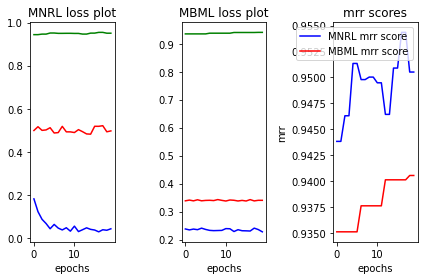

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(1,3,1)
plt.plot(MNRLtrain_loss, 'b-', label='train error')
plt.plot(MNRLval_loss, 'r-', label='val error')
plt.plot([el for el in scores_MNRL[1]], 'g-', label='mrr score')
plt.plot()
plt.title('MNRL loss plot')
plt.ylabel('')
plt.xlabel('epochs')

plt.subplot(1,3,2)
plt.plot(MBMLtrain_loss, 'b-', label='train error')
plt.plot(MBMLval_loss, 'r-', label='val error')
plt.plot([el for el in scores_MBML[1]], 'g-', label='mrr score')
plt.title('MBML loss plot')
plt.ylabel('')
plt.xlabel('epochs')

plt.subplot(1,3,3)
plt.plot([el for el in scores_MNRL[1]], 'b-', label='MNRL mrr score')
plt.plot([el for el in scores_MBML[1]], 'r-', label='MBML mrr score')
plt.title('mrr scores')
plt.ylabel('mrr')
plt.xlabel('epochs')

plt.legend()
plt.tight_layout()
plt.show()

# 5. Improving the score by creating synthetic data

In [ ]:
!pip install happytransformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def parse_text(lst_text,parse_file='train'):
  with open(base_path+'{}.txt'.format(parse_file),'w') as f:
    def add_sep(lst):
      return '[CLS]'+'[SEP] '.join(lst)
    
    def get_tweets(lst):
      return '[CLS] '+lst[0]
  
    #text = '\n'.join(map(add_sep,train_bert_text))
    text = ' \n\n'.join(map(get_tweets,train_bert_text))
    f.write(text)

parse_text(train_bert_text,'train')
parse_text(val_bert_text,'val')

In [ ]:
from happytransformer import HappyGeneration, GENSettings, GENTrainArgs 

model_gpt = HappyGeneration("GPT-NEO", "EleutherAI/gpt-neo-125M")
args = GENSettings(no_repeat_ngram_size=2, do_sample=True, early_stopping=False, top_k=50, temperature=0.7)

In [ ]:
train_args = GENTrainArgs(learning_rate =1e-5, num_train_epochs = 40)
model_gpt.train(base_path+"train.txt", args=train_args)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-68ea8e2ea6d2d939/0.0.0/21a506d1b2b34316b1e82d0bd79066905d846e5d7e619823c0dd338d6f1fa6ad. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 17
  Num Epochs = 40
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 680


Step,Training Loss
500,2.881100




Training completed. Do not forget to share your model on huggingface.co/models =)




In [ ]:
args = GENSettings(no_repeat_ngram_size=2, do_sample=True, early_stopping=True, top_k=50, temperature=1, max_length=80)

result = model_gpt.generate_text("[CLS]", args=args)
result.text

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


' He was playing “The Social Network” and the show was making it hard not to buy a ticket to join the social networking event. ‘Teen Witch’ is a must see.“I remember seeing him at the 2012 Democratic presidential parade dressed up as Donald Trump, and I was really stoked. I‘m thankful the Democrats changed their minds about taking our job in the'

We can use the code cell above to generate sentences, where the fake tweet and vclaim are separated by [SEP]  
The model is non deterministic.  
To generate new data, we take these new sentences and stop at the first dot encountered.  
We will add 400 samples (half of the training set more or less) and see whether the new data is too noisy or not. We do not apply any preprocessing (apart from getting rid of [SEP]) because the training data was already preprocessed, so we aim to obtain "clean" data.

In [ ]:
model_gpt1_3 = HappyGeneration("GPT-NEO", "EleutherAI/gpt-neo-1.3B")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--EleutherAI--gpt-neo-1.3B/snapshots/797174552ae47f449ab70b684cabcb6603e5e85e/config.json
Model config GPTNeoConfig {
  "_name_or_path": "EleutherAI/gpt-neo-1.3B",
  "activation_function": "gelu_new",
  "architectures": [
    "GPTNeoForCausalLM"
  ],
  "attention_dropout": 0,
  "attention_layers": [
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local"
  ],
  "attention_types": [
    [
      [
        "global",
        "local"
      ],
      12
    ]
  ],
  "bos_token_id": 50256,
  "embed_dropout": 0,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": n

In [ ]:
FEW_SHOT = True

training_prompt = ''

if FEW_SHOT:
  for i in range(16):
    training_prompt += 'Tweet: {}\nResponse: {}\n\n'.format(train_bert_text[i][0], train_bert_text[i][1])

In [ ]:
print(training_prompt)

Tweet: How are butterflies surviving the #AustralianFires? Julie Favell was putting out water for wildlife that survived the fires when she witnessed common brown butterflies (Heteronympha merope) fluttering in a moist wombat hole. Footage by Julie Favell  
Response: Are Wombats Inviting Animals Into Their Burrows to Escape Australia Fires? Wombats are herding animals and inviting them into their burrows in order to escape the wildfires in Australia.

Tweet: Trump needs to immediately divest from his businesses and comply with the emoluments clause. Iran could threaten Trump hotels *worldwide* and he could provoke war over the loss of revenue from skittish guests.  His business interests should not be driving military decisions. 
Response: No, U.S. Rep. Ilhan Omar Didn’t Give ‘Treasonous’ Military Advice to Iran In January 2020, U.S. Rep. Ilhan Omar advised Iran to attack Trump-branded hotels in the world, thus committing treason.

Tweet: A number of fraudulent text messages informing 

In [ ]:
from copy import deepcopy

def generate_fake_samples(tweet_model,vclaim_model,sentences,train_bert_text,training_prompt,quantity=400):
  counter = 0
  tweet_args = GENSettings(no_repeat_ngram_size=2, do_sample=True, early_stopping=True, top_k=50, temperature=1, max_length=50)
  vclaim_args = GENSettings(no_repeat_ngram_size=2, do_sample=True, early_stopping=True, top_k=50, temperature=0.1, max_length=50)
  while counter < quantity:
    text = []
    result = tweet_model.generate_text('[CLS]',args=tweet_args).text
    splitted_result = result.split('. ')

    tweet = '.'.join(splitted_result[:1])

    prompt = deepcopy(training_prompt)
    if FEW_SHOT:
      prompt += 'Tweet:{}\nResponse:'.format(tweet)
    else:
      prompt += 'A tweet is provided:{}\nThis is the claim that verifies the tweet:'.format(tweet)
    result = vclaim_model.generate_text(prompt,args=vclaim_args).text
    result = '.'.join(result.split('.')[:-1])

    sentences.append(result)

    text.append(tweet)
    text.append(result)

    train_bert_text.append(text)

    counter += 1
  return sentences, train_bert_text

In [ ]:
sentences, train_bert_text = generate_fake_samples(model_gpt,model_gpt1_3,sentences,train_bert_text,training_prompt,400)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [ ]:
import pickle

with open(base_path+'sentences.pkl','wb') as f:
  pickle.dump(sentences,f)

with open(base_path+'train_bert_text.pkl','wb') as f:
  pickle.dump(train_bert_text,f)

In [ ]:
train_bert_text[-20:]

[[' “If you vote for Donald Trump, you won’t even know who he was,” John McCain told Fox News a few days ago',
  ' What Did John Mccain Say About Donald J. Trump? John ’Mcc‘ McCain said Donald ”Trump“ was „not a person I would want to be president'],
 [' The administration of Donald Trump’s term officially confirms Trump is a serious person, only to have a second of the term on a four-year term expires on Jan 13',
  ' What Does the Administration of Trump Really Mean? President Trump has officially confirmed that he is serious, but he has not yet been sworn in. He has only been in office for four years'],
 [' It just sounds like a good thing for a school with a large number of students who are being hit with $1 million each for “racism and/or anti-immigrant/immigration/militant hate.” Maybe if ICE worked',
  ' What Does It Sound Like to Work for ICE? It sounds to me like the school is paying $100,000 per student for racism and anti immigrant hate, and the ICE is working to deport them'

We save and load back the 2 lists: loading both GPT and BERT models in the same runtime causes a CUDA out of memory

In [ ]:
import pickle

with open(base_path+'sentences.pkl','rb') as f:
  sentences = pickle.load(f)

with open(base_path+'train_bert_text.pkl','rb') as f:
  train_bert_text = pickle.load(f)

In [ ]:
def calculate_similarity(model,embeddings,json_file,result_file):
  tweet2vclaim = {}
  for i,tweet_row in test.iterrows():
      tweet = tweet_row['tweet']
      id = tweet_row['tweet_id']
      if id not in tweet2vclaim.keys():
          tweet2vclaim[id] = []
    
      tweet_embed = model.encode(tweet, convert_to_tensor=True)
      score_cos = util.cos_sim(tweet_embed, embeddings)[0].tolist()

      for j in range(len(score_cos)):
        if j < 13825:
          tweet2vclaim[id].append([vclaim.vclaim_id[j], score_cos[j]])
        else:
          tweet2vclaim[id].append(['vclaim_{}'.format(j), score_cos[j]])

  sortdict(tweet2vclaim)
  parse2file(tweet2vclaim,result_file)

The following training procedures have been deployed on different runtimes.  Both of them train with GPT augmented data. Eventually, they are compared to the standard BERT finetuning.   
The first one trains following a 64-shot prompting procedure.  
The second one trains in a 0-shot prompting fashion, following https://arxiv.org/pdf/2102.07350.pdf  

To perform the different trainings, change the FEW_SHOT parameter accordingly

### Few shot

In [ ]:
val_examples = [InputExample(texts = val_bert_text[i]) for i in range(len(val_bert_text))]
val_dataloader = DataLoader(val_examples, shuffle=False, batch_size=32)

train_examples = [InputExample(texts = train_bert_text[i]) for i in range(len(train_bert_text))]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)

optim_params_MNRL = {
    'weight_decay': 1e-2,
    'optimizer_params': {'lr':1e-2}
}

model = SentenceTransformer('all-mpnet-base-v2')

loss_function = losses.MultipleNegativesRankingLoss(model)

In [ ]:
MNRLgpt_train_loss, MNRLgpt_val_loss, scores_gpt_MNRL = train_model(model,loss_function,optim_params_MNRL,'train_MNRL','berttraineddict.json','berttrainedresult.txt')

[codecarbon INFO @ 19:21:56] [setup] RAM Tracking...
[codecarbon INFO @ 19:21:56] [setup] GPU Tracking...
[codecarbon INFO @ 19:21:56] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 19:21:56] [setup] CPU Tracking...
[codecarbon WARNING @ 19:21:56] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 19:21:58] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 19:21:58] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 19:21:58] >>> Tracker's metadata:
[codecarbon INFO @ 19:21:58]   Platform system: Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic
[codecarbon INFO @ 19:21:58]   Python version: 3.7.14
[codecarbon INFO @ 19:21:58]   Available RAM : 12.681 GB
[codecarbon INFO @ 19:21:58]   CPU count: 2
[codecarbon INFO @ 19:21:58]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 19:21:58]   GPU count: 1
[codecarbon INFO @ 19:21:58]   GPU mod

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 19:22:13] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:22:13] Energy consumed for all GPUs : 0.000299 kWh. All GPUs Power : 71.706 W
[codecarbon INFO @ 19:22:13] Energy consumed for all CPUs : 0.000177 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:22:13] 0.000496 kWh of electricity used since the begining.
[codecarbon INFO @ 19:22:28] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:22:28] Energy consumed for all GPUs : 0.000593 kWh. All GPUs Power : 70.72700000000002 W
[codecarbon INFO @ 19:22:28] Energy consumed for all CPUs : 0.000355 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:22:28] 0.000988 kWh of electricity used since the begining.


Train error: 0.18414762768110163
Val error: 0.5008816868066788


[codecarbon INFO @ 19:22:43] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:22:43] Energy consumed for all GPUs : 0.000887 kWh. All GPUs Power : 70.72700000000002 W
[codecarbon INFO @ 19:22:43] Energy consumed for all CPUs : 0.000532 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:22:43] 0.001478 kWh of electricity used since the begining.
[codecarbon INFO @ 19:22:58] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:22:58] Energy consumed for all GPUs : 0.001177 kWh. All GPUs Power : 69.649 W
[codecarbon INFO @ 19:22:58] Energy consumed for all CPUs : 0.000709 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:22:58] 0.001965 kWh of electricity used since the begining.
[codecarbon INFO @ 19:23:13] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:23:13] Energy consumed for all GPUs : 0.001465 kWh. All GPUs Power : 69.299 W
[codecarbon INFO @ 19:23:1

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9271356783919598, 0.9518425460636517, 0.9530988274706869, 0.9539363484087101, 0.9547140464225892, 0.9549325301455518, 0.9550191921900413]
MRR score 0.9437126595267247


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 19:24:43] Energy consumed for RAM : 0.000217 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:24:43] Energy consumed for all GPUs : 0.002384 kWh. All GPUs Power : 69.49600000000001 W
[codecarbon INFO @ 19:24:43] Energy consumed for all CPUs : 0.001949 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:24:43] 0.004550 kWh of electricity used since the begining.
[codecarbon INFO @ 19:24:58] Energy consumed for RAM : 0.000237 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:24:58] Energy consumed for all GPUs : 0.002669 kWh. All GPUs Power : 68.47300000000001 W
[codecarbon INFO @ 19:24:58] Energy consumed for all CPUs : 0.002125 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:24:58] 0.005031 kWh of electricity used since the begining.


Train error: 0.06525903703693889
Val error: 0.4802751626287188


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 19:25:13] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:25:13] Energy consumed for all GPUs : 0.002962 kWh. All GPUs Power : 70.487 W
[codecarbon INFO @ 19:25:13] Energy consumed for all CPUs : 0.002303 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:25:13] 0.005522 kWh of electricity used since the begining.
[codecarbon INFO @ 19:25:28] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:25:28] Energy consumed for all GPUs : 0.003261 kWh. All GPUs Power : 71.653 W
[codecarbon INFO @ 19:25:28] Energy consumed for all CPUs : 0.002480 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:25:28] 0.006017 kWh of electricity used since the begining.


Train error: 0.03907685422975766
Val error: 0.48696347006729673


[codecarbon INFO @ 19:25:43] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:25:43] Energy consumed for all GPUs : 0.003551 kWh. All GPUs Power : 69.79 W
[codecarbon INFO @ 19:25:43] Energy consumed for all CPUs : 0.002657 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:25:43] 0.006505 kWh of electricity used since the begining.
[codecarbon INFO @ 19:25:58] Energy consumed for RAM : 0.000316 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:25:58] Energy consumed for all GPUs : 0.003842 kWh. All GPUs Power : 69.79 W
[codecarbon INFO @ 19:25:58] Energy consumed for all CPUs : 0.002834 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:25:58] 0.006992 kWh of electricity used since the begining.
[codecarbon INFO @ 19:26:13] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:26:13] Energy consumed for all GPUs : 0.004018 kWh. All GPUs Power : 42.463 W
[codecarbon INFO @ 19:26:13] Energy con

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9422110552763819, 0.9627303182579564, 0.9647403685092129, 0.9652428810720267, 0.9656616415410386, 0.9656616415410386, 0.9658056609820861]
MRR score 0.9544991283187695


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 19:27:28] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:27:28] Energy consumed for all GPUs : 0.004817 kWh. All GPUs Power : 69.747 W
[codecarbon INFO @ 19:27:28] Energy consumed for all CPUs : 0.003896 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:27:28] 0.009148 kWh of electricity used since the begining.
[codecarbon INFO @ 19:27:43] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:27:43] Energy consumed for all GPUs : 0.005121 kWh. All GPUs Power : 72.98 W
[codecarbon INFO @ 19:27:43] Energy consumed for all CPUs : 0.004073 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:27:43] 0.009649 kWh of electricity used since the begining.


Train error: 0.029254411092934834
Val error: 0.49863756767341066


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 19:27:58] Energy consumed for RAM : 0.000474 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:27:58] Energy consumed for all GPUs : 0.005403 kWh. All GPUs Power : 67.731 W
[codecarbon INFO @ 19:27:58] Energy consumed for all CPUs : 0.004251 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:27:58] 0.010128 kWh of electricity used since the begining.
[codecarbon INFO @ 19:28:13] Energy consumed for RAM : 0.000494 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:28:13] Energy consumed for all GPUs : 0.005693 kWh. All GPUs Power : 69.747 W
[codecarbon INFO @ 19:28:13] Energy consumed for all CPUs : 0.004427 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:28:13] 0.010614 kWh of electricity used since the begining.


Train error: 0.023275857691738854
Val error: 0.47219583817890715


[codecarbon INFO @ 19:28:28] Energy consumed for RAM : 0.000514 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:28:28] Energy consumed for all GPUs : 0.005825 kWh. All GPUs Power : 31.29 W
[codecarbon INFO @ 19:28:28] Energy consumed for all CPUs : 0.004608 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:28:28] 0.010947 kWh of electricity used since the begining.
[codecarbon INFO @ 19:28:43] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:28:43] Energy consumed for all GPUs : 0.006116 kWh. All GPUs Power : 69.845 W
[codecarbon INFO @ 19:28:43] Energy consumed for all CPUs : 0.004785 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:28:43] 0.011434 kWh of electricity used since the begining.
[codecarbon INFO @ 19:28:58] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:28:58] Energy consumed for all GPUs : 0.006414 kWh. All GPUs Power : 71.849 W
[codecarbon INFO @ 19:28:58] Energy co

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9371859296482412, 0.9585427135678392, 0.9620603015075376, 0.9628978224455612, 0.9633546520481193, 0.9633546520481193, 0.9634673185552582]
MRR score 0.9521607858919416


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 19:30:29] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:30:29] Energy consumed for all GPUs : 0.007351 kWh. All GPUs Power : 70.237 W
[codecarbon INFO @ 19:30:29] Energy consumed for all CPUs : 0.006031 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:30:29] 0.014055 kWh of electricity used since the begining.
[codecarbon INFO @ 19:30:44] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:30:44] Energy consumed for all GPUs : 0.007638 kWh. All GPUs Power : 68.907 W
[codecarbon INFO @ 19:30:44] Energy consumed for all CPUs : 0.006208 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:30:44] 0.014539 kWh of electricity used since the begining.


Train error: 0.026830257587502467
Val error: 0.4978205923523222


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 19:30:59] Energy consumed for RAM : 0.000713 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:30:59] Energy consumed for all GPUs : 0.007941 kWh. All GPUs Power : 72.79200000000002 W
[codecarbon INFO @ 19:30:59] Energy consumed for all CPUs : 0.006385 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:30:59] 0.015039 kWh of electricity used since the begining.
[codecarbon INFO @ 19:31:14] Energy consumed for RAM : 0.000733 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:31:14] Energy consumed for all GPUs : 0.008233 kWh. All GPUs Power : 70.205 W
[codecarbon INFO @ 19:31:14] Energy consumed for all CPUs : 0.006562 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:31:14] 0.015528 kWh of electricity used since the begining.


Train error: 0.017266764135504337
Val error: 0.48830546012946535


[codecarbon INFO @ 19:31:29] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:31:29] Energy consumed for all GPUs : 0.008537 kWh. All GPUs Power : 72.935 W
[codecarbon INFO @ 19:31:29] Energy consumed for all CPUs : 0.006740 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:31:29] 0.016029 kWh of electricity used since the begining.
[codecarbon INFO @ 19:31:44] Energy consumed for RAM : 0.000772 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:31:44] Energy consumed for all GPUs : 0.008813 kWh. All GPUs Power : 66.26000000000002 W
[codecarbon INFO @ 19:31:44] Energy consumed for all CPUs : 0.006916 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:31:44] 0.016501 kWh of electricity used since the begining.
[codecarbon INFO @ 19:31:59] Energy consumed for RAM : 0.000792 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:31:59] Energy consumed for all GPUs : 0.009111 kWh. All GPUs Power : 71.608 W
[codecarbon INFO @ 19:31:5

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9422110552763819, 0.9610552763819096, 0.9635678391959799, 0.9652428810720267, 0.9656294291972684, 0.9656294291972684, 0.9657544496253164]
MRR score 0.9544479169619998


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 19:33:29] Energy consumed for RAM : 0.000911 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:33:29] Energy consumed for all GPUs : 0.010072 kWh. All GPUs Power : 70.825 W
[codecarbon INFO @ 19:33:29] Energy consumed for all CPUs : 0.008156 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:33:29] 0.019139 kWh of electricity used since the begining.
[codecarbon INFO @ 19:33:44] Energy consumed for RAM : 0.000930 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:33:44] Energy consumed for all GPUs : 0.010362 kWh. All GPUs Power : 69.453 W
[codecarbon INFO @ 19:33:44] Energy consumed for all CPUs : 0.008333 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:33:44] 0.019626 kWh of electricity used since the begining.


Train error: 0.01600177372548435
Val error: 0.49435208099228994


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 19:33:59] Energy consumed for RAM : 0.000950 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:33:59] Energy consumed for all GPUs : 0.010650 kWh. All GPUs Power : 69.20100000000001 W
[codecarbon INFO @ 19:33:59] Energy consumed for all CPUs : 0.008511 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:33:59] 0.020111 kWh of electricity used since the begining.
[codecarbon INFO @ 19:34:14] Energy consumed for RAM : 0.000970 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:34:14] Energy consumed for all GPUs : 0.010911 kWh. All GPUs Power : 62.867000000000004 W
[codecarbon INFO @ 19:34:14] Energy consumed for all CPUs : 0.008688 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:34:14] 0.020569 kWh of electricity used since the begining.


Train error: 0.023219065794316856
Val error: 0.4992666521242687


[codecarbon INFO @ 19:34:29] Energy consumed for RAM : 0.000990 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:34:29] Energy consumed for all GPUs : 0.011193 kWh. All GPUs Power : 67.57600000000001 W
[codecarbon INFO @ 19:34:29] Energy consumed for all CPUs : 0.008865 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:34:29] 0.021047 kWh of electricity used since the begining.
[codecarbon INFO @ 19:34:44] Energy consumed for RAM : 0.001010 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:34:44] Energy consumed for all GPUs : 0.011484 kWh. All GPUs Power : 70.041 W
[codecarbon INFO @ 19:34:44] Energy consumed for all CPUs : 0.009042 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:34:44] 0.021536 kWh of electricity used since the begining.
[codecarbon INFO @ 19:34:59] Energy consumed for RAM : 0.001029 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:34:59] Energy consumed for all GPUs : 0.011779 kWh. All GPUs Power : 70.879 W
[codecarbon INFO @ 19:34:5

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9321608040201005, 0.954355108877722, 0.9563651591289782, 0.9580402010050252, 0.9582914572864321, 0.9582914572864321, 0.9583985202333954]
MRR score 0.9470919875700788


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 19:36:14] Energy consumed for RAM : 0.001128 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:36:14] Energy consumed for all GPUs : 0.012586 kWh. All GPUs Power : 70.96600000000001 W
[codecarbon INFO @ 19:36:14] Energy consumed for all CPUs : 0.010104 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:36:14] 0.023819 kWh of electricity used since the begining.
[codecarbon INFO @ 19:36:29] Energy consumed for RAM : 0.001148 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:36:29] Energy consumed for all GPUs : 0.012878 kWh. All GPUs Power : 70.237 W
[codecarbon INFO @ 19:36:29] Energy consumed for all CPUs : 0.010281 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:36:29] 0.024308 kWh of electricity used since the begining.


Train error: 0.016379949019066867
Val error: 0.49092866693224224


[codecarbon INFO @ 19:36:44] Energy consumed for RAM : 0.001168 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:36:44] Energy consumed for all GPUs : 0.013064 kWh. All GPUs Power : 44.606 W
[codecarbon INFO @ 19:36:44] Energy consumed for all CPUs : 0.010459 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:36:44] 0.024690 kWh of electricity used since the begining.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 19:36:59] Energy consumed for RAM : 0.001188 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:36:59] Energy consumed for all GPUs : 0.013358 kWh. All GPUs Power : 70.629 W
[codecarbon INFO @ 19:36:59] Energy consumed for all CPUs : 0.010636 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:36:59] 0.025181 kWh of electricity used since the begining.
[codecarbon INFO @ 19:37:14] Energy consumed for RAM : 0.001207 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:37:14] Energy consumed for all GPUs : 0.013670 kWh. All GPUs Power : 74.996 W
[codecarbon INFO @ 19:37:14] Energy consumed for all CPUs : 0.010813 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:37:14] 0.025690 kWh of electricity used since the begining.


Train error: 0.01231527587745069
Val error: 0.4949264185769217


[codecarbon INFO @ 19:37:29] Energy consumed for RAM : 0.001227 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:37:29] Energy consumed for all GPUs : 0.013965 kWh. All GPUs Power : 70.72700000000002 W
[codecarbon INFO @ 19:37:29] Energy consumed for all CPUs : 0.010990 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:37:29] 0.026181 kWh of electricity used since the begining.
[codecarbon INFO @ 19:37:44] Energy consumed for RAM : 0.001247 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:37:44] Energy consumed for all GPUs : 0.014255 kWh. All GPUs Power : 69.845 W
[codecarbon INFO @ 19:37:44] Energy consumed for all CPUs : 0.011167 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:37:44] 0.026668 kWh of electricity used since the begining.
[codecarbon INFO @ 19:37:59] Energy consumed for RAM : 0.001267 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:38:00] Energy consumed for all GPUs : 0.014389 kWh. All GPUs Power : 32.081 W
[codecarbon INFO @ 19:38:0

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9271356783919598, 0.9518425460636517, 0.9538525963149078, 0.9546901172529314, 0.9554438860971524, 0.9555607494838533, 0.9555859575188141]
MRR score 0.9442794248554975


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 19:39:15] Energy consumed for RAM : 0.001366 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:39:15] Energy consumed for all GPUs : 0.015195 kWh. All GPUs Power : 69.355 W
[codecarbon INFO @ 19:39:15] Energy consumed for all CPUs : 0.012237 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:39:15] 0.028798 kWh of electricity used since the begining.
[codecarbon INFO @ 19:39:30] Energy consumed for RAM : 0.001386 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:39:30] Energy consumed for all GPUs : 0.015463 kWh. All GPUs Power : 64.436 W
[codecarbon INFO @ 19:39:30] Energy consumed for all CPUs : 0.012414 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:39:30] 0.029263 kWh of electricity used since the begining.


Train error: 0.020867272903591295
Val error: 0.5069136491843632


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 19:39:45] Energy consumed for RAM : 0.001406 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:39:45] Energy consumed for all GPUs : 0.015749 kWh. All GPUs Power : 68.767 W
[codecarbon INFO @ 19:39:45] Energy consumed for all CPUs : 0.012591 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:39:45] 0.029745 kWh of electricity used since the begining.
[codecarbon INFO @ 19:40:00] Energy consumed for RAM : 0.001425 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:40:00] Energy consumed for all GPUs : 0.016042 kWh. All GPUs Power : 70.433 W
[codecarbon INFO @ 19:40:00] Energy consumed for all CPUs : 0.012768 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:40:00] 0.030235 kWh of electricity used since the begining.


Train error: 0.025578211507404615
Val error: 0.4995843746832439


[codecarbon INFO @ 19:40:15] Energy consumed for RAM : 0.001445 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:40:15] Energy consumed for all GPUs : 0.016341 kWh. All GPUs Power : 71.76 W
[codecarbon INFO @ 19:40:15] Energy consumed for all CPUs : 0.012945 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:40:15] 0.030731 kWh of electricity used since the begining.
[codecarbon INFO @ 19:40:30] Energy consumed for RAM : 0.001465 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:40:30] Energy consumed for all GPUs : 0.016632 kWh. All GPUs Power : 70.139 W
[codecarbon INFO @ 19:40:30] Energy consumed for all CPUs : 0.013122 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:40:30] 0.031219 kWh of electricity used since the begining.
[codecarbon INFO @ 19:40:45] Energy consumed for RAM : 0.001485 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:40:45] Energy consumed for all GPUs : 0.016925 kWh. All GPUs Power : 70.28000000000002 W
[codecarbon INFO @ 19:40:45

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9271356783919598, 0.9510050251256281, 0.9532663316582914, 0.9556592486240727, 0.9556592486240727, 0.9556592486240727, 0.9557364754406653]
MRR score 0.9444299427773488


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 19:42:15] Energy consumed for RAM : 0.001603 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:42:15] Energy consumed for all GPUs : 0.017848 kWh. All GPUs Power : 68.571 W
[codecarbon INFO @ 19:42:15] Energy consumed for all CPUs : 0.014361 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:42:15] 0.033812 kWh of electricity used since the begining.
[codecarbon INFO @ 19:42:30] Energy consumed for RAM : 0.001623 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:42:30] Energy consumed for all GPUs : 0.018294 kWh. All GPUs Power : 107.301 W
[codecarbon INFO @ 19:42:30] Energy consumed for all CPUs : 0.014538 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:42:30] 0.034456 kWh of electricity used since the begining.


Train error: 0.026528879890592133
Val error: 0.48264020894254955


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 19:42:45] Energy consumed for RAM : 0.001643 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:42:45] Energy consumed for all GPUs : 0.018745 kWh. All GPUs Power : 108.36900000000001 W
[codecarbon INFO @ 19:42:45] Energy consumed for all CPUs : 0.014716 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:42:45] 0.035104 kWh of electricity used since the begining.
[codecarbon INFO @ 19:43:00] Energy consumed for RAM : 0.001663 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:43:00] Energy consumed for all GPUs : 0.019041 kWh. All GPUs Power : 71.119 W
[codecarbon INFO @ 19:43:00] Energy consumed for all CPUs : 0.014892 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:43:00] 0.035596 kWh of electricity used since the begining.


Train error: 0.02377905986213591
Val error: 0.49605901539325714


[codecarbon INFO @ 19:43:15] Energy consumed for RAM : 0.001683 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:43:15] Energy consumed for all GPUs : 0.019333 kWh. All GPUs Power : 70.237 W
[codecarbon INFO @ 19:43:15] Energy consumed for all CPUs : 0.015070 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:43:15] 0.036085 kWh of electricity used since the begining.
[codecarbon INFO @ 19:43:30] Energy consumed for RAM : 0.001702 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:43:30] Energy consumed for all GPUs : 0.019624 kWh. All GPUs Power : 69.845 W
[codecarbon INFO @ 19:43:30] Energy consumed for all CPUs : 0.015247 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:43:30] 0.036573 kWh of electricity used since the begining.
[codecarbon INFO @ 19:43:45] Energy consumed for RAM : 0.001722 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:43:45] Energy consumed for all GPUs : 0.019918 kWh. All GPUs Power : 70.81400000000001 W
[codecarbon INFO @ 19:43:4

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9371859296482412, 0.9577051926298158, 0.9599664991624792, 0.96143216080402, 0.9617671691792294, 0.9619681742043551, 0.9619898195013644]
MRR score 0.9506832868380479


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 19:45:00] Energy consumed for RAM : 0.001821 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:45:00] Energy consumed for all GPUs : 0.020727 kWh. All GPUs Power : 71.902 W
[codecarbon INFO @ 19:45:00] Energy consumed for all CPUs : 0.016309 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:45:00] 0.038857 kWh of electricity used since the begining.
[codecarbon INFO @ 19:45:15] Energy consumed for RAM : 0.001841 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:45:15] Energy consumed for all GPUs : 0.021015 kWh. All GPUs Power : 69.25700000000002 W
[codecarbon INFO @ 19:45:15] Energy consumed for all CPUs : 0.016486 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:45:15] 0.039342 kWh of electricity used since the begining.


Train error: 0.02263472677134958
Val error: 0.49363083285944803


[codecarbon INFO @ 19:45:30] Energy consumed for RAM : 0.001861 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:45:30] Energy consumed for all GPUs : 0.021201 kWh. All GPUs Power : 44.606 W
[codecarbon INFO @ 19:45:30] Energy consumed for all CPUs : 0.016663 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:45:30] 0.039725 kWh of electricity used since the begining.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 19:45:45] Energy consumed for RAM : 0.001880 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:45:45] Energy consumed for all GPUs : 0.021505 kWh. All GPUs Power : 73.229 W
[codecarbon INFO @ 19:45:45] Energy consumed for all CPUs : 0.016840 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:45:45] 0.040226 kWh of electricity used since the begining.
[codecarbon INFO @ 19:46:00] Energy consumed for RAM : 0.001900 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:46:00] Energy consumed for all GPUs : 0.021798 kWh. All GPUs Power : 70.28000000000002 W
[codecarbon INFO @ 19:46:00] Energy consumed for all CPUs : 0.017017 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:46:00] 0.040715 kWh of electricity used since the begining.


Train error: 0.017724011835525744
Val error: 0.47986745621476856


[codecarbon INFO @ 19:46:15] Energy consumed for RAM : 0.001920 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:46:15] Energy consumed for all GPUs : 0.022098 kWh. All GPUs Power : 72.00000000000001 W
[codecarbon INFO @ 19:46:15] Energy consumed for all CPUs : 0.017194 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:46:15] 0.041212 kWh of electricity used since the begining.
[codecarbon INFO @ 19:46:30] Energy consumed for RAM : 0.001940 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:46:30] Energy consumed for all GPUs : 0.022386 kWh. All GPUs Power : 69.25700000000002 W
[codecarbon INFO @ 19:46:30] Energy consumed for all CPUs : 0.017371 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:46:30] 0.041697 kWh of electricity used since the begining.
[codecarbon INFO @ 19:46:45] Energy consumed for RAM : 0.001959 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:46:45] Energy consumed for all GPUs : 0.022539 kWh. All GPUs Power : 36.686 W
[codecarbon INF

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9271356783919598, 0.9484924623115578, 0.9517587939698491, 0.9532244556113902, 0.953611003736632, 0.9537366318773354, 0.9537553823460971]
MRR score 0.9424488496827805


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 19:48:00] Energy consumed for RAM : 0.002058 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:48:00] Energy consumed for all GPUs : 0.023341 kWh. All GPUs Power : 71.76 W
[codecarbon INFO @ 19:48:00] Energy consumed for all CPUs : 0.018433 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:48:00] 0.043832 kWh of electricity used since the begining.
[codecarbon INFO @ 19:48:15] Energy consumed for RAM : 0.002078 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:48:15] Energy consumed for all GPUs : 0.023629 kWh. All GPUs Power : 69.214 W
[codecarbon INFO @ 19:48:15] Energy consumed for all CPUs : 0.018610 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:48:15] 0.044317 kWh of electricity used since the begining.


Train error: 0.016957162592964443
Val error: 0.5003440827131271


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 19:48:30] Energy consumed for RAM : 0.002097 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:48:30] Energy consumed for all GPUs : 0.023910 kWh. All GPUs Power : 67.437 W
[codecarbon INFO @ 19:48:30] Energy consumed for all CPUs : 0.018787 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:48:30] 0.044795 kWh of electricity used since the begining.
[codecarbon INFO @ 19:48:45] Energy consumed for RAM : 0.002117 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:48:45] Energy consumed for all GPUs : 0.024205 kWh. All GPUs Power : 70.825 W
[codecarbon INFO @ 19:48:45] Energy consumed for all CPUs : 0.018965 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:48:45] 0.045286 kWh of electricity used since the begining.


Train error: 0.018336693527281137
Val error: 0.4976760063852583


[codecarbon INFO @ 19:49:00] Energy consumed for RAM : 0.002137 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:49:01] Energy consumed for all GPUs : 0.024381 kWh. All GPUs Power : 42.364000000000004 W
[codecarbon INFO @ 19:49:01] Energy consumed for all CPUs : 0.019142 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:49:01] 0.045660 kWh of electricity used since the begining.
[codecarbon INFO @ 19:49:15] Energy consumed for RAM : 0.002157 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:49:16] Energy consumed for all GPUs : 0.024669 kWh. All GPUs Power : 69.20100000000001 W
[codecarbon INFO @ 19:49:16] Energy consumed for all CPUs : 0.019319 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:49:16] 0.046144 kWh of electricity used since the begining.
[codecarbon INFO @ 19:49:30] Energy consumed for RAM : 0.002176 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:49:31] Energy consumed for all GPUs : 0.024959 kWh. All GPUs Power : 69.69200000000001 W
[co

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9271356783919598, 0.9551926298157455, 0.9574539363484087, 0.9581718114381431, 0.9581718114381431, 0.9584002262394222, 0.9584834851801924]
MRR score 0.9471769525168758


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 19:51:01] Energy consumed for RAM : 0.002295 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:51:01] Energy consumed for all GPUs : 0.025848 kWh. All GPUs Power : 60.488 W
[codecarbon INFO @ 19:51:01] Energy consumed for all CPUs : 0.020557 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:51:01] 0.048700 kWh of electricity used since the begining.
[codecarbon INFO @ 19:51:16] Energy consumed for RAM : 0.002315 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:51:16] Energy consumed for all GPUs : 0.026135 kWh. All GPUs Power : 68.907 W
[codecarbon INFO @ 19:51:16] Energy consumed for all CPUs : 0.020734 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:51:16] 0.049184 kWh of electricity used since the begining.


Train error: 0.015461897540693539
Val error: 0.48728092866284506


[codecarbon INFO @ 19:51:25] Energy consumed for RAM : 0.002327 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 19:51:25] Energy consumed for all GPUs : 0.026221 kWh. All GPUs Power : 32.77400000000001 W
[codecarbon INFO @ 19:51:25] Energy consumed for all CPUs : 0.020846 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:51:25] 0.049394 kWh of electricity used since the begining.


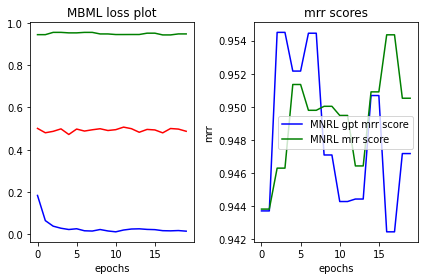

In [ ]:
plt.subplot(1,2,1)
plt.plot(MNRLgpt_train_loss, 'b-', label='train error')
plt.plot(MNRLgpt_val_loss, 'r-', label='val error')
plt.plot([el for el in scores_gpt_MNRL[1]], 'g-', label='mrr score')
plt.title('MBML loss plot')
plt.ylabel('')
plt.xlabel('epochs')

plt.subplot(1,2,2)
plt.plot([el for el in scores_gpt_MNRL[1]], 'b-', label='MNRL gpt mrr score')
plt.plot([el for el in scores_MNRL[1]], 'g-', label='MNRL mrr score')
plt.title('mrr scores')
plt.ylabel('mrr')
plt.xlabel('epochs')

plt.legend()
plt.tight_layout()
plt.show()

### Zero-shot

In [ ]:
val_examples = [InputExample(texts = val_bert_text[i]) for i in range(len(val_bert_text))]
val_dataloader = DataLoader(val_examples, shuffle=False, batch_size=32)

train_examples = [InputExample(texts = train_bert_text[i]) for i in range(len(train_bert_text))]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)

optim_params_MNRL = {
    'weight_decay': 1e-2,
    'optimizer_params': {'lr':1e-2}
}

model = SentenceTransformer('all-mpnet-base-v2')

loss_function = losses.MultipleNegativesRankingLoss(model)

MNRLgpt_train_loss, MNRLgpt_val_loss, scores_gpt_MNRL = train_model(model,loss_function,optim_params_MNRL,'train_MNRL','berttraineddict.json','berttrainedresult.txt')

[codecarbon INFO @ 16:26:18] [setup] RAM Tracking...
[codecarbon INFO @ 16:26:18] [setup] GPU Tracking...
[codecarbon INFO @ 16:26:18] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:26:18] [setup] CPU Tracking...
[codecarbon WARNING @ 16:26:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 16:26:19] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:26:19] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 16:26:19] >>> Tracker's metadata:
[codecarbon INFO @ 16:26:19]   Platform system: Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic
[codecarbon INFO @ 16:26:19]   Python version: 3.7.14
[codecarbon INFO @ 16:26:19]   Available RAM : 51.000 GB
[codecarbon INFO @ 16:26:19]   CPU count: 8
[codecarbon INFO @ 16:26:19]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 16:26:19]   GPU count: 1
[codecarbon INFO @ 16:26:19]   GPU mod

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 16:26:27] Energy consumed for RAM : 0.000159 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:26:27] Energy consumed for all GPUs : 0.000466 kWh. All GPUs Power : 70.519 W
[codecarbon INFO @ 16:26:27] Energy consumed for all CPUs : 0.000354 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:26:27] 0.000980 kWh of electricity used since the begining.
[codecarbon INFO @ 16:26:34] Energy consumed for RAM : 0.000080 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:26:34] Energy consumed for all GPUs : 0.000273 kWh. All GPUs Power : 65.43 W
[codecarbon INFO @ 16:26:34] Energy consumed for all CPUs : 0.000177 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:26:34] 0.000530 kWh of electricity used since the begining.
[codecarbon INFO @ 16:26:42] Energy consumed for RAM : 0.000239 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:26:42] Energy consumed for all GPUs : 0.000748 kWh. All GPUs Power : 67.53700000000002 W
[codecarbon INFO @ 16:26

Train error: 0.3287111945254238
Val error: 0.5059809003557477


[codecarbon INFO @ 16:26:57] Energy consumed for RAM : 0.000319 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:26:57] Energy consumed for all GPUs : 0.001025 kWh. All GPUs Power : 66.602 W
[codecarbon INFO @ 16:26:57] Energy consumed for all CPUs : 0.000708 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:26:57] 0.002052 kWh of electricity used since the begining.
[codecarbon INFO @ 16:27:04] Energy consumed for RAM : 0.000239 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:27:04] Energy consumed for all GPUs : 0.000858 kWh. All GPUs Power : 69.684 W
[codecarbon INFO @ 16:27:04] Energy consumed for all CPUs : 0.000531 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:27:04] 0.001628 kWh of electricity used since the begining.
[codecarbon INFO @ 16:27:12] Energy consumed for RAM : 0.000398 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:27:12] Energy consumed for all GPUs : 0.001305 kWh. All GPUs Power : 67.342 W
[codecarbon INFO @ 16:27:12] Energ

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9271356783919598, 0.9501675041876047, 0.952680067001675, 0.9533082077051925, 0.9536947558304342, 0.953930522772071, 0.954043627906073]
MRR score 0.9427370952427564


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 16:28:49] Energy consumed for RAM : 0.000795 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:28:49] Energy consumed for all GPUs : 0.002076 kWh. All GPUs Power : 70.465 W
[codecarbon INFO @ 16:28:49] Energy consumed for all CPUs : 0.001771 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:28:49] 0.004641 kWh of electricity used since the begining.
[codecarbon INFO @ 16:28:57] Energy consumed for RAM : 0.000954 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:28:57] Energy consumed for all GPUs : 0.002524 kWh. All GPUs Power : 71.929 W
[codecarbon INFO @ 16:28:57] Energy consumed for all CPUs : 0.002124 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:28:57] 0.005602 kWh of electricity used since the begining.
[codecarbon INFO @ 16:29:04] Energy consumed for RAM : 0.000875 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:29:04] Energy consumed for all GPUs : 0.002358 kWh. All GPUs Power : 67.732 W
[codecarbon INFO @ 16:29:04] Energ

Train error: 0.11824653368737352
Val error: 0.5028824061155319


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 16:29:19] Energy consumed for RAM : 0.000954 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:29:19] Energy consumed for all GPUs : 0.002649 kWh. All GPUs Power : 70.075 W
[codecarbon INFO @ 16:29:19] Energy consumed for all CPUs : 0.002125 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:29:19] 0.005729 kWh of electricity used since the begining.
[codecarbon INFO @ 16:29:27] Energy consumed for RAM : 0.001113 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:29:27] Energy consumed for all GPUs : 0.003070 kWh. All GPUs Power : 61.795 W
[codecarbon INFO @ 16:29:27] Energy consumed for all CPUs : 0.002479 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:29:27] 0.006661 kWh of electricity used since the begining.
[codecarbon INFO @ 16:29:34] Energy consumed for RAM : 0.001034 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:29:34] Energy consumed for all GPUs : 0.002926 kWh. All GPUs Power : 66.42300000000002 W
[codecarbon INFO @ 16:2

Train error: 0.05568506941199303
Val error: 0.4863723771912711


[codecarbon INFO @ 16:29:49] Energy consumed for RAM : 0.001113 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:29:49] Energy consumed for all GPUs : 0.003231 kWh. All GPUs Power : 73.4 W
[codecarbon INFO @ 16:29:49] Energy consumed for all CPUs : 0.002479 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:29:49] 0.006824 kWh of electricity used since the begining.
[codecarbon INFO @ 16:29:57] Energy consumed for RAM : 0.001272 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:29:57] Energy consumed for all GPUs : 0.003769 kWh. All GPUs Power : 69.349 W
[codecarbon INFO @ 16:29:57] Energy consumed for all CPUs : 0.002833 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:29:57] 0.007874 kWh of electricity used since the begining.
[codecarbon INFO @ 16:30:04] Energy consumed for RAM : 0.001193 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:30:04] Energy consumed for all GPUs : 0.003515 kWh. All GPUs Power : 68.22 W
[codecarbon INFO @ 16:30:04] Energy c

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9321608040201005, 0.9526800670016751, 0.9551926298157455, 0.9567480258435032, 0.9570620961952621, 0.957333724607594, 0.9573711537068054]
MRR score 0.9460646210434888


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 16:31:43] Energy consumed for RAM : 0.001831 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:31:43] Energy consumed for all GPUs : 0.005048 kWh. All GPUs Power : 71.29 W
[codecarbon INFO @ 16:31:43] Energy consumed for all CPUs : 0.004078 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:31:43] 0.010957 kWh of electricity used since the begining.
[codecarbon INFO @ 16:31:49] Energy consumed for RAM : 0.001749 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:31:49] Energy consumed for all GPUs : 0.004741 kWh. All GPUs Power : 70.714 W
[codecarbon INFO @ 16:31:49] Energy consumed for all CPUs : 0.003896 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:31:49] 0.010385 kWh of electricity used since the begining.
[codecarbon INFO @ 16:31:58] Energy consumed for RAM : 0.001911 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:31:58] Energy consumed for all GPUs : 0.005346 kWh. All GPUs Power : 71.787 W
[codecarbon INFO @ 16:31:58] Energy

Train error: 0.031176279951499675
Val error: 0.52812702528068


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 16:32:13] Energy consumed for RAM : 0.001991 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:32:13] Energy consumed for all GPUs : 0.005616 kWh. All GPUs Power : 64.84400000000001 W
[codecarbon INFO @ 16:32:13] Energy consumed for all CPUs : 0.004433 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:32:13] 0.012039 kWh of electricity used since the begining.
[codecarbon INFO @ 16:32:19] Energy consumed for RAM : 0.001908 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:32:19] Energy consumed for all GPUs : 0.005320 kWh. All GPUs Power : 68.025 W
[codecarbon INFO @ 16:32:19] Energy consumed for all CPUs : 0.004250 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:32:19] 0.011477 kWh of electricity used since the begining.
[codecarbon INFO @ 16:32:28] Energy consumed for RAM : 0.002070 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:32:28] Energy consumed for all GPUs : 0.005916 kWh. All GPUs Power : 71.937 W
[codecarbon INFO @ 16:3

Train error: 0.01943135027020042
Val error: 0.5145122749464852


[codecarbon INFO @ 16:32:43] Energy consumed for RAM : 0.002150 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:32:43] Energy consumed for all GPUs : 0.006047 kWh. All GPUs Power : 31.676999999999996 W
[codecarbon INFO @ 16:32:43] Energy consumed for all CPUs : 0.004787 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:32:43] 0.012984 kWh of electricity used since the begining.
[codecarbon INFO @ 16:32:49] Energy consumed for RAM : 0.002067 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:32:49] Energy consumed for all GPUs : 0.005907 kWh. All GPUs Power : 70.90900000000002 W
[codecarbon INFO @ 16:32:49] Energy consumed for all CPUs : 0.004604 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:32:49] 0.012579 kWh of electricity used since the begining.
[codecarbon INFO @ 16:32:58] Energy consumed for RAM : 0.002229 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:32:58] Energy consumed for all GPUs : 0.006343 kWh. All GPUs Power : 71.007 W
[codecarbon

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9371859296482412, 0.9560301507537688, 0.9585427135678392, 0.9598887293610912, 0.9601679030070991, 0.9603411832011729, 0.9604499201632942]
MRR score 0.9491433874999776


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 16:34:34] Energy consumed for RAM : 0.002623 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:34:34] Energy consumed for all GPUs : 0.007293 kWh. All GPUs Power : 70.66 W
[codecarbon INFO @ 16:34:34] Energy consumed for all CPUs : 0.005843 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:34:34] 0.015760 kWh of electricity used since the begining.
[codecarbon INFO @ 16:34:43] Energy consumed for RAM : 0.002786 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:34:43] Energy consumed for all GPUs : 0.007579 kWh. All GPUs Power : 70.85600000000001 W
[codecarbon INFO @ 16:34:43] Energy consumed for all CPUs : 0.006204 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:34:43] 0.016569 kWh of electricity used since the begining.
[codecarbon INFO @ 16:34:49] Energy consumed for RAM : 0.002703 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:34:49] Energy consumed for all GPUs : 0.007539 kWh. All GPUs Power : 59.092 W
[codecarbon INFO @ 16:34

Train error: 0.013681522757427669
Val error: 0.5289205632039479


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 16:35:04] Energy consumed for RAM : 0.002782 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:35:04] Energy consumed for all GPUs : 0.007837 kWh. All GPUs Power : 71.494 W
[codecarbon INFO @ 16:35:04] Energy consumed for all CPUs : 0.006197 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:35:04] 0.016817 kWh of electricity used since the begining.
[codecarbon INFO @ 16:35:13] Energy consumed for RAM : 0.002946 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:35:13] Energy consumed for all GPUs : 0.008105 kWh. All GPUs Power : 68.708 W
[codecarbon INFO @ 16:35:13] Energy consumed for all CPUs : 0.006558 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:35:13] 0.017608 kWh of electricity used since the begining.
[codecarbon INFO @ 16:35:19] Energy consumed for RAM : 0.002862 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:35:19] Energy consumed for all GPUs : 0.008123 kWh. All GPUs Power : 68.806 W
[codecarbon INFO @ 16:35:19] Energ

Train error: 0.013877798989644936
Val error: 0.5398173736674445


[codecarbon INFO @ 16:35:34] Energy consumed for RAM : 0.002942 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:35:34] Energy consumed for all GPUs : 0.008299 kWh. All GPUs Power : 42.215 W
[codecarbon INFO @ 16:35:34] Energy consumed for all CPUs : 0.006551 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:35:34] 0.017792 kWh of electricity used since the begining.
[codecarbon INFO @ 16:35:43] Energy consumed for RAM : 0.003105 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:35:43] Energy consumed for all GPUs : 0.008671 kWh. All GPUs Power : 65.137 W
[codecarbon INFO @ 16:35:43] Energy consumed for all CPUs : 0.006912 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:35:43] 0.018687 kWh of electricity used since the begining.
[codecarbon INFO @ 16:35:49] Energy consumed for RAM : 0.003021 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:35:49] Energy consumed for all GPUs : 0.008585 kWh. All GPUs Power : 68.806 W
[codecarbon INFO @ 16:35:49] Energ

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9422110552763819, 0.9593802345058627, 0.9606365159128979, 0.9623115577889447, 0.9623115577889447, 0.9627966952087555, 0.9628252620679233]
MRR score 0.9515187294046067


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 16:37:28] Energy consumed for RAM : 0.003664 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:37:28] Energy consumed for all GPUs : 0.010069 kWh. All GPUs Power : 71.202 W
[codecarbon INFO @ 16:37:28] Energy consumed for all CPUs : 0.008157 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:37:28] 0.021889 kWh of electricity used since the begining.
[codecarbon INFO @ 16:37:34] Energy consumed for RAM : 0.003578 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:37:34] Energy consumed for all GPUs : 0.009789 kWh. All GPUs Power : 64.94200000000001 W
[codecarbon INFO @ 16:37:34] Energy consumed for all CPUs : 0.007969 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:37:34] 0.021335 kWh of electricity used since the begining.
[codecarbon INFO @ 16:37:43] Energy consumed for RAM : 0.003743 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:37:43] Energy consumed for all GPUs : 0.010441 kWh. All GPUs Power : 89.34 W
[codecarbon INFO @ 16:37

Train error: 0.011384128762170133
Val error: 0.5413815336568015


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 16:37:58] Energy consumed for RAM : 0.003823 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:37:58] Energy consumed for all GPUs : 0.010745 kWh. All GPUs Power : 73.153 W
[codecarbon INFO @ 16:37:58] Energy consumed for all CPUs : 0.008511 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:37:58] 0.023079 kWh of electricity used since the begining.
[codecarbon INFO @ 16:38:04] Energy consumed for RAM : 0.003737 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:38:04] Energy consumed for all GPUs : 0.010341 kWh. All GPUs Power : 69.446 W
[codecarbon INFO @ 16:38:05] Energy consumed for all CPUs : 0.008323 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:38:05] 0.022401 kWh of electricity used since the begining.
[codecarbon INFO @ 16:38:13] Energy consumed for RAM : 0.003903 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:38:13] Energy consumed for all GPUs : 0.011099 kWh. All GPUs Power : 85.034 W
[codecarbon INFO @ 16:38:13] Energ

Train error: 0.010108224709064847
Val error: 0.521346811737333


[codecarbon INFO @ 16:38:28] Energy consumed for RAM : 0.003982 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:38:28] Energy consumed for all GPUs : 0.011278 kWh. All GPUs Power : 42.903 W
[codecarbon INFO @ 16:38:28] Energy consumed for all CPUs : 0.008865 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:38:28] 0.024125 kWh of electricity used since the begining.
[codecarbon INFO @ 16:38:34] Energy consumed for RAM : 0.003896 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:38:34] Energy consumed for all GPUs : 0.010922 kWh. All GPUs Power : 69.446 W
[codecarbon INFO @ 16:38:34] Energy consumed for all CPUs : 0.008677 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:38:35] 0.023495 kWh of electricity used since the begining.
[codecarbon INFO @ 16:38:43] Energy consumed for RAM : 0.004062 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:38:43] Energy consumed for all GPUs : 0.011572 kWh. All GPUs Power : 70.812 W
[codecarbon INFO @ 16:38:43] Energ

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9321608040201005, 0.9501675041876048, 0.9534338358458962, 0.9541517109356304, 0.9544473065608152, 0.9549217065327027, 0.9549393733688506]
MRR score 0.9436328407055341


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 16:40:28] Energy consumed for RAM : 0.004618 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:40:28] Energy consumed for all GPUs : 0.012789 kWh. All GPUs Power : 69.489 W
[codecarbon INFO @ 16:40:28] Energy consumed for all CPUs : 0.010281 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:40:28] 0.027689 kWh of electricity used since the begining.
[codecarbon INFO @ 16:40:35] Energy consumed for RAM : 0.004533 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:40:35] Energy consumed for all GPUs : 0.012450 kWh. All GPUs Power : 71.051 W
[codecarbon INFO @ 16:40:35] Energy consumed for all CPUs : 0.010095 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:40:35] 0.027078 kWh of electricity used since the begining.
[codecarbon INFO @ 16:40:43] Energy consumed for RAM : 0.004698 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:40:43] Energy consumed for all GPUs : 0.013081 kWh. All GPUs Power : 70.172 W
[codecarbon INFO @ 16:40:43] Energ

Train error: 0.012584860255868224
Val error: 0.543193763920239


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 16:40:58] Energy consumed for RAM : 0.004777 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:40:58] Energy consumed for all GPUs : 0.013380 kWh. All GPUs Power : 71.787 W
[codecarbon INFO @ 16:40:58] Energy consumed for all CPUs : 0.010635 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:40:58] 0.028793 kWh of electricity used since the begining.
[codecarbon INFO @ 16:41:05] Energy consumed for RAM : 0.004692 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:41:05] Energy consumed for all GPUs : 0.013038 kWh. All GPUs Power : 70.812 W
[codecarbon INFO @ 16:41:05] Energy consumed for all CPUs : 0.010449 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:41:05] 0.028180 kWh of electricity used since the begining.
[codecarbon INFO @ 16:41:13] Energy consumed for RAM : 0.004857 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:41:13] Energy consumed for all GPUs : 0.013668 kWh. All GPUs Power : 69.154 W
[codecarbon INFO @ 16:41:13] Energ

Train error: 0.013567291555534067
Val error: 0.524374783039093


[codecarbon INFO @ 16:41:28] Energy consumed for RAM : 0.004937 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:41:28] Energy consumed for all GPUs : 0.013956 kWh. All GPUs Power : 69.056 W
[codecarbon INFO @ 16:41:28] Energy consumed for all CPUs : 0.010989 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:41:28] 0.029882 kWh of electricity used since the begining.
[codecarbon INFO @ 16:41:35] Energy consumed for RAM : 0.004851 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:41:35] Energy consumed for all GPUs : 0.013533 kWh. All GPUs Power : 69.141 W
[codecarbon INFO @ 16:41:35] Energy consumed for all CPUs : 0.010803 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:41:35] 0.029188 kWh of electricity used since the begining.
[codecarbon INFO @ 16:41:43] Energy consumed for RAM : 0.005016 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:41:43] Energy consumed for all GPUs : 0.014246 kWh. All GPUs Power : 69.782 W
[codecarbon INFO @ 16:41:43] Energ

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9221105527638191, 0.9484924623115578, 0.9484924623115578, 0.9506700167504187, 0.9506700167504187, 0.9508058309565848, 0.9509969999320855]
MRR score 0.9396904672687689


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 16:43:20] Energy consumed for RAM : 0.005408 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:43:20] Energy consumed for all GPUs : 0.014916 kWh. All GPUs Power : 69.044 W
[codecarbon INFO @ 16:43:20] Energy consumed for all CPUs : 0.012044 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:43:20] 0.032367 kWh of electricity used since the begining.
[codecarbon INFO @ 16:43:28] Energy consumed for RAM : 0.005573 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:43:28] Energy consumed for all GPUs : 0.015469 kWh. All GPUs Power : 70.519 W
[codecarbon INFO @ 16:43:28] Energy consumed for all CPUs : 0.012407 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:43:28] 0.033448 kWh of electricity used since the begining.
[codecarbon INFO @ 16:43:35] Energy consumed for RAM : 0.005487 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:43:35] Energy consumed for all GPUs : 0.015205 kWh. All GPUs Power : 69.392 W
[codecarbon INFO @ 16:43:35] Energ

Train error: 0.01448717682950174
Val error: 0.5384656531470162


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 16:43:50] Energy consumed for RAM : 0.005567 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:43:50] Energy consumed for all GPUs : 0.015500 kWh. All GPUs Power : 70.953 W
[codecarbon INFO @ 16:43:50] Energy consumed for all CPUs : 0.012398 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:43:50] 0.033465 kWh of electricity used since the begining.
[codecarbon INFO @ 16:43:58] Energy consumed for RAM : 0.005732 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:43:58] Energy consumed for all GPUs : 0.016052 kWh. All GPUs Power : 71.787 W
[codecarbon INFO @ 16:43:58] Energy consumed for all CPUs : 0.012761 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:43:58] 0.034545 kWh of electricity used since the begining.
[codecarbon INFO @ 16:44:05] Energy consumed for RAM : 0.005646 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:44:05] Energy consumed for all GPUs : 0.015792 kWh. All GPUs Power : 69.97700000000002 W
[codecarbon INFO @ 16:4

Train error: 0.021719096554749597
Val error: 0.5445565666471209


[codecarbon INFO @ 16:44:20] Energy consumed for RAM : 0.005726 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:44:20] Energy consumed for all GPUs : 0.015968 kWh. All GPUs Power : 42.411 W
[codecarbon INFO @ 16:44:20] Energy consumed for all CPUs : 0.012752 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:44:20] 0.034447 kWh of electricity used since the begining.
[codecarbon INFO @ 16:44:28] Energy consumed for RAM : 0.005891 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:44:28] Energy consumed for all GPUs : 0.016607 kWh. All GPUs Power : 69.196 W
[codecarbon INFO @ 16:44:28] Energy consumed for all CPUs : 0.013115 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:44:28] 0.035613 kWh of electricity used since the begining.
[codecarbon INFO @ 16:44:35] Energy consumed for RAM : 0.005805 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:44:35] Energy consumed for all GPUs : 0.016266 kWh. All GPUs Power : 71.548 W
[codecarbon INFO @ 16:44:35] Energ

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9321608040201005, 0.9551926298157455, 0.9577051926298158, 0.9585427135678392, 0.9585427135678392, 0.9588780945886273, 0.9589764164785384]
MRR score 0.9476698838152218


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 16:46:14] Energy consumed for RAM : 0.006450 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:46:14] Energy consumed for all GPUs : 0.017997 kWh. All GPUs Power : 69.97700000000002 W
[codecarbon INFO @ 16:46:14] Energy consumed for all CPUs : 0.014360 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:46:14] 0.038807 kWh of electricity used since the begining.
[codecarbon INFO @ 16:46:20] Energy consumed for RAM : 0.006365 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:46:20] Energy consumed for all GPUs : 0.017463 kWh. All GPUs Power : 60.719 W
[codecarbon INFO @ 16:46:20] Energy consumed for all CPUs : 0.014175 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:46:20] 0.038003 kWh of electricity used since the begining.
[codecarbon INFO @ 16:46:29] Energy consumed for RAM : 0.006530 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:46:29] Energy consumed for all GPUs : 0.018273 kWh. All GPUs Power : 66.268 W
[codecarbon INFO @ 16:4

Train error: 0.00801821362830723
Val error: 0.514879760997636


[codecarbon INFO @ 16:46:44] Energy consumed for RAM : 0.006610 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:46:44] Energy consumed for all GPUs : 0.018455 kWh. All GPUs Power : 43.787 W
[codecarbon INFO @ 16:46:44] Energy consumed for all CPUs : 0.014714 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:46:44] 0.039779 kWh of electricity used since the begining.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 16:46:50] Energy consumed for RAM : 0.006524 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:46:50] Energy consumed for all GPUs : 0.018052 kWh. All GPUs Power : 70.368 W
[codecarbon INFO @ 16:46:50] Energy consumed for all CPUs : 0.014529 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:46:50] 0.039105 kWh of electricity used since the begining.
[codecarbon INFO @ 16:46:59] Energy consumed for RAM : 0.006689 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:46:59] Energy consumed for all GPUs : 0.018744 kWh. All GPUs Power : 69.446 W
[codecarbon INFO @ 16:46:59] Energy consumed for all CPUs : 0.014891 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:46:59] 0.040324 kWh of electricity used since the begining.
[codecarbon INFO @ 16:47:05] Energy consumed for RAM : 0.006604 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:47:05] Energy consumed for all GPUs : 0.018340 kWh. All GPUs Power : 69.099 W
[codecarbon INFO @ 16:47:05] Energ

Train error: 0.009057612896676323
Val error: 0.5385266308273587


[codecarbon INFO @ 16:47:20] Energy consumed for RAM : 0.006683 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:47:20] Energy consumed for all GPUs : 0.018618 kWh. All GPUs Power : 66.993 W
[codecarbon INFO @ 16:47:20] Energy consumed for all CPUs : 0.014883 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:47:20] 0.040185 kWh of electricity used since the begining.
[codecarbon INFO @ 16:47:29] Energy consumed for RAM : 0.006848 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:47:29] Energy consumed for all GPUs : 0.019299 kWh. All GPUs Power : 68.123 W
[codecarbon INFO @ 16:47:29] Energy consumed for all CPUs : 0.015245 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:47:29] 0.041392 kWh of electricity used since the begining.
[codecarbon INFO @ 16:47:35] Energy consumed for RAM : 0.006763 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:47:35] Energy consumed for all GPUs : 0.018907 kWh. All GPUs Power : 69.196 W
[codecarbon INFO @ 16:47:35] Energ

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9271356783919598, 0.9501675041876048, 0.9546901172529314, 0.9546901172529314, 0.9546901172529314, 0.9548157453936348, 0.9550058113188852]
MRR score 0.9436992786555686


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 16:49:14] Energy consumed for RAM : 0.007404 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:49:14] Energy consumed for all GPUs : 0.020483 kWh. All GPUs Power : 60.914 W
[codecarbon INFO @ 16:49:14] Energy consumed for all CPUs : 0.016485 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:49:14] 0.044372 kWh of electricity used since the begining.
[codecarbon INFO @ 16:49:20] Energy consumed for RAM : 0.007320 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:49:20] Energy consumed for all GPUs : 0.020129 kWh. All GPUs Power : 67.57900000000001 W
[codecarbon INFO @ 16:49:20] Energy consumed for all CPUs : 0.016300 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:49:20] 0.043749 kWh of electricity used since the begining.
[codecarbon INFO @ 16:49:29] Energy consumed for RAM : 0.007484 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:49:29] Energy consumed for all GPUs : 0.020773 kWh. All GPUs Power : 69.641 W
[codecarbon INFO @ 16:4

Train error: 0.01108484268556104
Val error: 0.5063986054488591


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 16:49:44] Energy consumed for RAM : 0.007564 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:49:44] Energy consumed for all GPUs : 0.021069 kWh. All GPUs Power : 71.104 W
[codecarbon INFO @ 16:49:44] Energy consumed for all CPUs : 0.016839 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:49:44] 0.045472 kWh of electricity used since the begining.
[codecarbon INFO @ 16:49:50] Energy consumed for RAM : 0.007479 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:49:50] Energy consumed for all GPUs : 0.020862 kWh. All GPUs Power : 70.617 W
[codecarbon INFO @ 16:49:50] Energy consumed for all CPUs : 0.016654 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:49:50] 0.044995 kWh of electricity used since the begining.
[codecarbon INFO @ 16:49:59] Energy consumed for RAM : 0.007643 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:49:59] Energy consumed for all GPUs : 0.021368 kWh. All GPUs Power : 71.982 W
[codecarbon INFO @ 16:49:59] Energ

Train error: 0.011595824034118681
Val error: 0.5692018525941032


[codecarbon INFO @ 16:50:14] Energy consumed for RAM : 0.007723 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:50:14] Energy consumed for all GPUs : 0.021655 kWh. All GPUs Power : 68.806 W
[codecarbon INFO @ 16:50:14] Energy consumed for all CPUs : 0.017193 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:50:14] 0.046571 kWh of electricity used since the begining.
[codecarbon INFO @ 16:50:20] Energy consumed for RAM : 0.007638 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:50:20] Energy consumed for all GPUs : 0.021445 kWh. All GPUs Power : 70.129 W
[codecarbon INFO @ 16:50:20] Energy consumed for all CPUs : 0.017008 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:50:20] 0.046092 kWh of electricity used since the begining.
[codecarbon INFO @ 16:50:29] Energy consumed for RAM : 0.007802 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:50:29] Energy consumed for all GPUs : 0.021946 kWh. All GPUs Power : 70.031 W
[codecarbon INFO @ 16:50:29] Energ

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9321608040201005, 0.9518425460636517, 0.9551088777219431, 0.9558267528116775, 0.9558267528116775, 0.9560758563464874, 0.9561871253320681]
MRR score 0.9448805926687515


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 16:52:05] Energy consumed for RAM : 0.008195 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:52:05] Energy consumed for all GPUs : 0.022833 kWh. All GPUs Power : 70.226 W
[codecarbon INFO @ 16:52:05] Energy consumed for all CPUs : 0.018248 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:52:05] 0.049276 kWh of electricity used since the begining.
[codecarbon INFO @ 16:52:14] Energy consumed for RAM : 0.008358 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:52:14] Energy consumed for all GPUs : 0.023176 kWh. All GPUs Power : 70.714 W
[codecarbon INFO @ 16:52:14] Energy consumed for all CPUs : 0.018610 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:52:14] 0.050145 kWh of electricity used since the begining.
[codecarbon INFO @ 16:52:20] Energy consumed for RAM : 0.008275 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:52:20] Energy consumed for all GPUs : 0.023113 kWh. All GPUs Power : 67.342 W
[codecarbon INFO @ 16:52:20] Energ

Train error: 0.012991762182393455
Val error: 0.5529139574084964


[codecarbon INFO @ 16:52:35] Energy consumed for RAM : 0.008354 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:52:35] Energy consumed for all GPUs : 0.023249 kWh. All GPUs Power : 32.563 W
[codecarbon INFO @ 16:52:35] Energy consumed for all CPUs : 0.018602 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:52:35] 0.050205 kWh of electricity used since the begining.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 16:52:44] Energy consumed for RAM : 0.008518 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:52:44] Energy consumed for all GPUs : 0.023765 kWh. All GPUs Power : 72.035 W
[codecarbon INFO @ 16:52:44] Energy consumed for all CPUs : 0.018964 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:52:44] 0.051247 kWh of electricity used since the begining.
[codecarbon INFO @ 16:52:50] Energy consumed for RAM : 0.008434 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:52:50] Energy consumed for all GPUs : 0.023493 kWh. All GPUs Power : 58.603 W
[codecarbon INFO @ 16:52:50] Energy consumed for all CPUs : 0.018780 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:52:50] 0.050706 kWh of electricity used since the begining.
[codecarbon INFO @ 16:52:59] Energy consumed for RAM : 0.008597 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:52:59] Energy consumed for all GPUs : 0.024052 kWh. All GPUs Power : 69.099 W
[codecarbon INFO @ 16:52:59] Energ

Train error: 0.009257766721451557
Val error: 0.5713580804211753


[codecarbon INFO @ 16:53:14] Energy consumed for RAM : 0.008677 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:53:14] Energy consumed for all GPUs : 0.024339 kWh. All GPUs Power : 68.946 W
[codecarbon INFO @ 16:53:14] Energy consumed for all CPUs : 0.019318 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:53:14] 0.052335 kWh of electricity used since the begining.
[codecarbon INFO @ 16:53:20] Energy consumed for RAM : 0.008593 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:53:20] Energy consumed for all GPUs : 0.024082 kWh. All GPUs Power : 70.031 W
[codecarbon INFO @ 16:53:20] Energy consumed for all CPUs : 0.019134 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:53:20] 0.051809 kWh of electricity used since the begining.
[codecarbon INFO @ 16:53:29] Energy consumed for RAM : 0.008756 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:53:29] Energy consumed for all GPUs : 0.024631 kWh. All GPUs Power : 70.031 W
[codecarbon INFO @ 16:53:29] Energ

NoTuning Baseline for Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9321608040201005, 0.9493299832495813, 0.9525963149078727, 0.9532244556113902, 0.953520051236575, 0.9538059357875349, 0.9539227855176856]
MRR score 0.942616252854369


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

[codecarbon INFO @ 16:54:59] Energy consumed for RAM : 0.009233 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:54:59] Energy consumed for all GPUs : 0.025563 kWh. All GPUs Power : 30.808000000000003 W
[codecarbon INFO @ 16:54:59] Energy consumed for all CPUs : 0.020557 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:54:59] 0.055352 kWh of electricity used since the begining.
[codecarbon INFO @ 16:55:06] Energy consumed for RAM : 0.009149 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:55:06] Energy consumed for all GPUs : 0.025297 kWh. All GPUs Power : 66.895 W
[codecarbon INFO @ 16:55:06] Energy consumed for all CPUs : 0.020373 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:55:06] 0.054819 kWh of electricity used since the begining.
[codecarbon INFO @ 16:55:14] Energy consumed for RAM : 0.009313 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:55:14] Energy consumed for all GPUs : 0.025819 kWh. All GPUs Power : 61.501000000000005 W
[codecarbo

Train error: 0.01216668425063529
Val error: 0.5371752083301544


[codecarbon INFO @ 16:55:29] Energy consumed for RAM : 0.009392 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:55:29] Energy consumed for all GPUs : 0.026001 kWh. All GPUs Power : 43.885 W
[codecarbon INFO @ 16:55:29] Energy consumed for all CPUs : 0.020911 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:55:29] 0.056304 kWh of electricity used since the begining.
[codecarbon INFO @ 16:55:30] Energy consumed for RAM : 0.009277 kWh. RAM Power : 19.125030040740967 W
[codecarbon INFO @ 16:55:30] Energy consumed for all GPUs : 0.025697 kWh. All GPUs Power : 43.492000000000004 W
[codecarbon INFO @ 16:55:30] Energy consumed for all CPUs : 0.020657 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:55:30] 0.055632 kWh of electricity used since the begining.


In [ ]:
"""import pickle

with open(base_path+'analysis/MNRLgpt_train_loss','wb') as f:
  pickle.dump(MNRLgpt_train_loss,f)

with open(base_path+'analysis/MNRLgpt_val_loss','wb') as f:
  pickle.dump(MNRLgpt_val_loss,f)

with open(base_path+'analysis/scores_gpt_MNRL','wb') as f:
  pickle.dump(scores_gpt_MNRL,f)"""

In [ ]:
"""with open(base_path+'analysis/MNRLgpt_train_loss','rb') as f:
  MNRLgpt_train_loss = pickle.load(f)

with open(base_path+'analysis/MNRLgpt_val_loss','rb') as f:
  MNRLgpt_val_loss = pickle.load(f)

with open(base_path+'analysis/scores_gpt_MNRL','rb') as f:
  scores_gpt_MNRL = pickle.load(f)"""

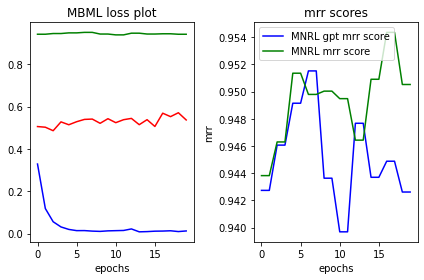

In [ ]:
plt.subplot(1,2,1)
plt.plot(MNRLgpt_train_loss, 'b-', label='train error')
plt.plot(MNRLgpt_val_loss, 'r-', label='val error')
plt.plot([el for el in scores_gpt_MNRL[1]], 'g-', label='mrr score')
plt.title('MBML loss plot')
plt.ylabel('')
plt.xlabel('epochs')

plt.subplot(1,2,2)
plt.plot([el for el in scores_gpt_MNRL[1]], 'b-', label='MNRL gpt mrr score')
plt.plot([el for el in scores_MNRL[1]], 'g-', label='MNRL mrr score')
plt.title('mrr scores')
plt.ylabel('mrr')
plt.xlabel('epochs')

plt.legend()
plt.tight_layout()
plt.show()

The few shot score has slightly improved the base bert score.  
The zero shot score, following https://arxiv.org/pdf/2102.07350.pdf, seems to create noisy samples and, thus, the score has decreased.  
Anyway, we have to bear in mind that we used smaller batch sizes than the one used in the standard bert finetuning, due to RAM usage limits. The MNRL loss works better with larger batches, so it is safe to assume that these scores are lower bounds than the actual values we would obtain with the same batch size.  

TODO:  
- Create RNN, LSTM baselines;  
- Figure out how to obtain train and val loss from sentence transformer models + plots [DONE]
- Run codecarbon to investigate co2 emissions [DONE]
- For gpt: see whether, by increasing the number of samples in prompt, the score improves. [DONE]

# 6. Analysis on computation and CO2 emissions

In the notebook, we have gathered some information about the co2 emissions of every model. In the chart below, we can see a summary of these values

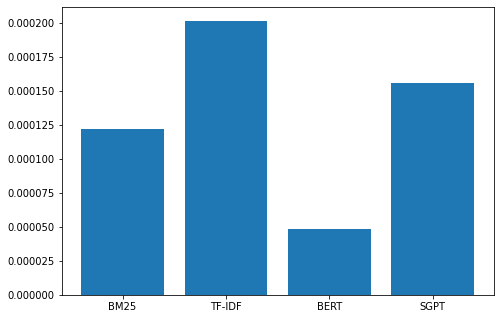

In [ ]:
emissions_df = pd.read_csv(base_path+"analysis/co2/emissions.csv")
emissions = emissions_df["emissions"].tolist()[:4]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
model_names = ['BM25', 'TF-IDF', 'BERT', 'SGPT']
ax.bar(model_names,emissions)
plt.show()

Now let's see the emissions during training...

In [ ]:
emissions = []

emissions.append(emissions_df.loc[emissions_df["project_name"] == "train_MNRL"]["emissions"])
emissions.append(emissions_df.loc[emissions_df["project_name"] == "train_MBML"]["emissions"])
emissions.append(emissions_df.loc[emissions_df["project_name"] == "train_MNRL_zero"]["emissions"] + emissions_df.loc[emissions_df["project_name"] == "GPT zero"]["emissions"])
emissions.append(emissions_df.loc[emissions_df["project_name"] == "train_MNRL_few"]["emissions"] + emissions_df.loc[emissions_df["project_name"] == "GPT few"]["emissions"])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
model_names = ['MNRL','MBML','MNRL zero','MNRL few']
ax.bar(model_names,emissions)
plt.show()

We can see that, during inference, semantical models seem to be better and produce less emissions.  
During training, MNRL seems to be less complex (and also faster) than MBML, which needs to produce triples for TripletLoss and, thus, has an increased overhead.  
Now let's compare the scores when using vclaim, vclaim+title or vclaim+title+subtitle and their corresponding co2 emissions.